# Assignment Week 1-4:Image (Pre-)Processing, Quality Assurance prior to DL training.ipynb

Created by: **Mikael Del Castillo**, **Malinda Huang**

**Overview**:

This assigment will go over:
* Basic data exploration
* Preprocessing MRI with TorchIO
  - Spatial transformations
  - Data augmentation
  - Intensity transformations




# Import libraries, packages, and dataset
First, lets import all the libraries and dataset needed for this assigment.

We will visualize the MRI images of another patient from the same Kaggle dataset that we used in the workshop (https://www.kaggle.com/datasets/awsaf49/brats20-dataset-training-validation).

In [2]:
!pip install torchio==0.18.70 --quiet
!curl -s -o colormap.txt https://raw.githubusercontent.com/thenineteen/Semiology-Visualisation-Tool/master/slicer/Resources/Color/BrainAnatomyLabelsV3_0.txt

# Loading and processing
import os
import numpy as np
import pandas as pd
import nibabel as nib

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline 

# Torch IO
import copy
import time
import pprint

import torch
import torchio as tio
import seaborn as sns; sns.set() # statistical data visualization

sns.set_style("whitegrid", {'axes.grid' : False})
%config InlineBackend.figure_format = 'retina'
torch.manual_seed(14041931)
mni = tio.datasets.Colin27()

print('TorchIO version:', tio.__version__)
print('Last run on', time.ctime())


TorchIO version: 0.18.70
Last run on Fri Apr 14 12:59:20 2023


In [2]:
import shutil
project_dir = 'ImagePreprocessing'
%cd /content
if os.path.exists(project_dir):
  shutil.rmtree(project_dir)
else: 
  os.mkdir(project_dir)
!git clone https://github.com/MalindaH/ImagePreprocessing.git
%cd ImagePreprocessing
!unzip /content/ImagePreprocessing/BraTS20_Training_002_t2.nii.zip -d /content/BraTS20_Training_002_t2.nii
!rm -rf *.zip

/content
Cloning into 'ImagePreprocessing'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 6 (delta 0), reused 6 (delta 0), pack-reused 0
Unpacking objects: 100% (6/6), 1.96 MiB | 7.00 MiB/s, done.
/content/ImagePreprocessing
Archive:  /content/ImagePreprocessing/BraTS20_Training_002_t2.nii.zip
replace /content/BraTS20_Training_002_t2.nii/BraTS20_Training_002_t2.nii? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# Excercise 1: Data Exploration

Let's explore our dataset by loading one sample MRI scan!
Use the path defined bellow. 

In [3]:
# Use this path when loading your image, make sure you run this section
file_path = "/content/BraTS20_Training_002_t2.nii/BraTS20_Training_002_t2.nii"

In [4]:
#@title ## Run me! (Visualization functions from the workshop) 

#Function to display row of image slices
def show_slices(slices):
    fig, axes = plt.subplots(1, len(slices), figsize=(15,15))
    for idx, slice in enumerate(slices):
        axes[idx].imshow(slice.T, cmap="gray", origin="lower")

    axes[0].set_xlabel('Second dim voxel coords.', fontsize=12)
    axes[0].set_ylabel('Third dim voxel coords', fontsize=12)
    axes[0].set_title('First dimension (i), slice {}'.format(i), fontsize=15)

    axes[1].set_xlabel('First dim voxel coords.', fontsize=12)
    axes[1].set_ylabel('Third dim voxel coords', fontsize=12)
    axes[1].set_title('Second dimension (j), slice {}'.format(j), fontsize=15)
  
    axes[2].set_xlabel('First dim voxel coords.', fontsize=12)
    axes[2].set_ylabel('Second dim voxel coords', fontsize=12)
    axes[2].set_title('Third dimension (k), slice {}'.format(k), fontsize=15)

# modify above show_slices() fnc to include visualization of coordinate location
def add_coords(slices):
  fig, axes = plt.subplots(1, len(slices), figsize=(15,15))
  for idx, slice in enumerate(slices):
    axes[idx].imshow(slice.T, cmap="gray", origin="lower")

    axes[0].set_xlabel('Second dim voxel coords.', fontsize=12)
    axes[0].set_ylabel('Third dim voxel coords', fontsize=12)
    axes[0].set_title('First dimension (i), slice {}'.format(i), fontsize=15)

    axes[1].set_xlabel('First dim voxel coords.', fontsize=12)
    axes[1].set_ylabel('Third dim voxel coords', fontsize=12)
    axes[1].set_title('Second dimension (j), slice {}'.format(j), fontsize=15)
  
    axes[2].set_xlabel('First dim voxel coords.', fontsize=12)
    axes[2].set_ylabel('Second dim voxel coords', fontsize=12)
    axes[2].set_title('Third dimension (k), slice {}'.format(k), fontsize=15)  
    
    # plot the 3D coordinate in red
    axes[0].add_patch((patches.Rectangle((j, k), 3, 3, linewidth=2, edgecolor='r', facecolor='none')))
    axes[1].add_patch((patches.Rectangle((i, k), 3, 3, linewidth=2, edgecolor='r', facecolor='none')))
    axes[2].add_patch((patches.Rectangle((i, j), 3, 3, linewidth=2, edgecolor='r', facecolor='none')))

# Functions required for TorchIO 
def get_bounds(self):
    """Get image bounds in mm.

    Returns:
        np.ndarray: [description]
    """
    first_index = 3 * (-0.5,)
    last_index = np.array(self.spatial_shape) - 0.5
    first_point = nib.affines.apply_affine(self.affine, first_index)
    last_point = nib.affines.apply_affine(self.affine, last_index)
    array = np.array((first_point, last_point))
    bounds_x, bounds_y, bounds_z = array.T.tolist()
    return bounds_x, bounds_y, bounds_z

def to_pil(image):
    from PIL import Image
    from IPython.display import display
    data = image.numpy().squeeze().T
    data = data.astype(np.uint8)
    image = Image.fromarray(data)
    w, h = image.size
    display(image)
    print()  # in case multiple images are being displayed

def stretch(img):
    p1, p99 = np.percentile(img, (1, 99))
    from skimage import exposure
    img_rescale = exposure.rescale_intensity(img, in_range=(p1, p99))
    return img_rescale

def show_fpg(
        subject,
        to_ras=False,
        stretch_slices=True,
        indices=None,
        parcellation=False,
        ):
    subject = tio.ToCanonical()(subject) if to_ras else subject
    def flip(x):
        return np.rot90(x) # flip 90 degrees
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    if indices is None:
        t1_half_shape = torch.Tensor(subject.t1.spatial_shape) // 2
        t1_i, t1_j, t1_k = t1_half_shape.long()
        t1_i -= 5  # use a better slice

        t2_half_shape = torch.Tensor(subject.t2.spatial_shape) // 2
        t2_i, t2_j, t2_k = t2_half_shape.long()
        t2_i -= 5  # use a better slice
    else:
        t1_i, t1_j, t1_k = indices
    t1bounds_x, t1bounds_y, t1bounds_z = get_bounds(subject.t1)  ###
    t2bounds_x, t2bounds_y, t2bounds_z = get_bounds(subject.t2)

    orientation = ''.join(subject.t1.orientation)
    if orientation != 'RAS':
        import warnings
        warnings.warn(f'Image orientation should be RAS+, not {orientation}+')
    
    kwargs = dict(cmap='gray', interpolation='none')
    data = subject['t1'].data
    slices = data[0, t1_i], data[0, :, t1_j], data[0, ..., t1_k]
    if stretch_slices:
        slices = [stretch(s.numpy()) for s in slices]
    sag, cor, axi = slices
    
    axes[0, 0].imshow(flip(sag), extent=t1bounds_y + t1bounds_z, **kwargs)
    axes[0, 1].imshow(flip(cor), extent=t1bounds_x + t1bounds_z, **kwargs)
    axes[0, 2].imshow(flip(axi), extent=t1bounds_x + t1bounds_y, **kwargs)
    axes[0, 0].set_title('T1', fontsize=15)
    axes[0, 1].set_title('T1', fontsize=15)
    axes[0, 2].set_title('T1', fontsize=15)
    

    kwargs = dict(cmap='gray', interpolation='none')
    data2 = subject['t2'].data
    slicest2 = data2[0, t2_i], data2[0, :, t2_j], data2[0, ..., t2_k]
    if stretch_slices:
        slicest2 = [stretch(s.numpy()) for s in slicest2]
    sagt2, cort2, axit2 = slicest2
    
    axes[1, 0].imshow(flip(sagt2), extent=t2bounds_y + t2bounds_z, **kwargs)
    axes[1, 1].imshow(flip(cort2), extent=t2bounds_x + t2bounds_z, **kwargs)
    axes[1, 2].imshow(flip(axit2), extent=t2bounds_x + t2bounds_y, **kwargs)
    axes[1, 0].set_title('T2', fontsize=15)
    axes[1, 1].set_title('T2', fontsize=15)
    axes[1, 2].set_title('T2', fontsize=15)

def show_rbf(
        subject,
        to_ras=False,
        stretch_slices=True,
        indices=None,
        intensity_name='t1',
        parcellation=True,
        ):
    subject = tio.ToCanonical()(subject) if to_ras else subject
    def flip(x):
        return np.rot90(x)
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    if indices is None:
        half_shape = torch.Tensor(subject.spatial_shape) // 2
        i, j, k = half_shape.long()
        i -= 5  # use a better slice
    else:
        i, j, k = indices
    bounds_x, bounds_y, bounds_z = get_bounds(subject.t1)  ###

    orientation = ''.join(subject.t1.orientation)
    if orientation != 'RAS':
        import warnings
        warnings.warn(f'Image orientation should be RAS+, not {orientation}+')
    
    kwargs = dict(cmap='gray', interpolation='none')
    data = subject[intensity_name].data
    slices = data[0, i], data[0, :, j], data[0, ..., k]
    if stretch_slices:
        slices = [stretch(s.numpy()) for s in slices]
    sag, cor, axi = slices
    
    axes[0, 0].imshow(flip(sag), extent=bounds_y + bounds_z, **kwargs)
    axes[0, 1].imshow(flip(cor), extent=bounds_x + bounds_z, **kwargs)
    axes[0, 2].imshow(flip(axi), extent=bounds_x + bounds_y, **kwargs)

    kwargs = dict(interpolation='none')
    data = subject.seg.data
    slices = data[0, i], data[0, :, j], data[0, ..., k]
    if parcellation:
        sag, cor, axi = [color_table.colorize(s.long()) if s.max() > 1 else s for s in slices]
    else:
        sag, cor, axi = slices
    axes[1, 0].imshow(flip(sag), extent=bounds_y + bounds_z, **kwargs)
    axes[1, 1].imshow(flip(cor), extent=bounds_x + bounds_z, **kwargs)
    axes[1, 2].imshow(flip(axi), extent=bounds_x + bounds_y, **kwargs)
    
    plt.tight_layout()


class ColorTable:
    def __init__(self, colors_path):
        self.df = self.read_color_table(colors_path)

    @staticmethod
    def read_color_table(colors_path):
        df = pd.read_csv(
            colors_path,
            sep=' ',
            header=None,
            names=['Label', 'Name', 'R', 'G', 'B', 'A'],
            index_col='Label',
        )
        return df

    def get_color(self, label: int):
        """
        There must be nicer ways of doing this
        """
        try:
            rgb = (
                self.df.loc[label].R,
                self.df.loc[label].G,
                self.df.loc[label].B,
            )
        except KeyError:
            rgb = 0, 0, 0
        return rgb

    def colorize(self, label_map: np.ndarray) -> np.ndarray:
        rgb = np.stack(3 * [label_map], axis=-1)
        for label in np.unique(label_map):
            mask = label_map == label
            color = self.get_color(label)
            rgb[mask] = color
        return rgb

color_table = ColorTable('/content/colormap.txt')

## Your tasks: 
1. Load the data file and get the image data. Print the data type and its size.
2. Display the values of a 5x5 voxel of the center of the dataframe
3. Visualize the slices over the first, second and third dimensions of the image array using the center coordinates


In [5]:
# Type your code here 
img = nib.load(file_path)

# print the image type
print(type(img))

# print the image size
img.shape

<class 'nibabel.nifti1.Nifti1Image'>


(240, 240, 155)

In [11]:
# Diplay the value of a 5x5 voxel of the center of the dataframe

# first get the image data
img_data = img.get_fdata()
print(type(img_data))

mid_vox = img_data[118:123, 118:123, 108:113]
print(mid_vox)

<class 'numpy.memmap'>
[[[274. 195. 182. 178. 176.]
  [259. 183. 194. 192. 192.]
  [227. 175. 195. 185. 189.]
  [199. 180. 191. 186. 189.]
  [188. 189. 172. 182. 199.]]

 [[238. 196. 183. 177. 214.]
  [233. 182. 174. 190. 222.]
  [231. 181. 178. 203. 213.]
  [184. 179. 161. 191. 221.]
  [184. 163. 183. 183. 216.]]

 [[224. 194. 195. 192. 202.]
  [216. 193. 189. 197. 211.]
  [209. 191. 185. 166. 205.]
  [192. 173. 178. 182. 213.]
  [193. 191. 180. 208. 229.]]

 [[179. 175. 179. 172. 163.]
  [181. 189. 165. 172. 173.]
  [176. 174. 165. 165. 168.]
  [169. 156. 170. 161. 168.]
  [179. 167. 162. 174. 182.]]

 [[192. 183. 163. 165. 163.]
  [182. 187. 153. 154. 166.]
  [172. 150. 161. 152. 160.]
  [179. 162. 149. 175. 171.]
  [177. 164. 159. 173. 184.]]]


The value the first, second and third dimensions are 119, 119 and 77


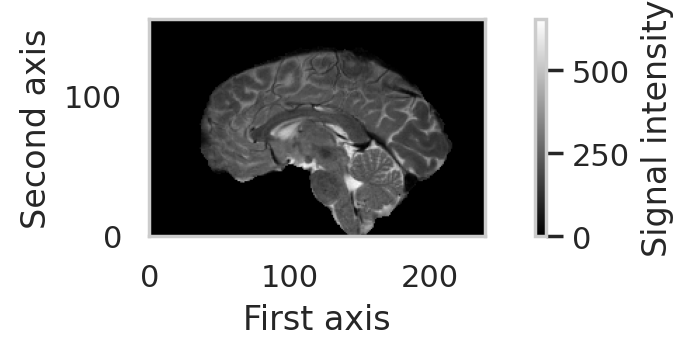

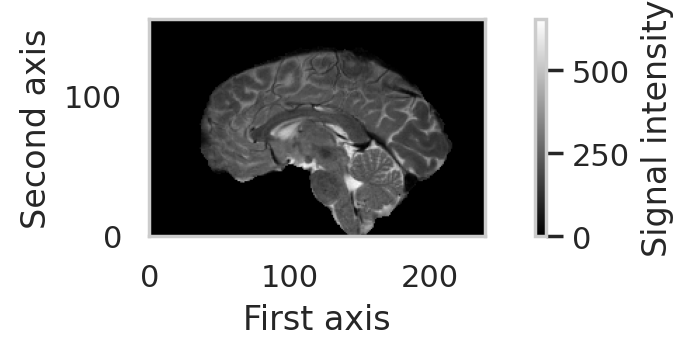

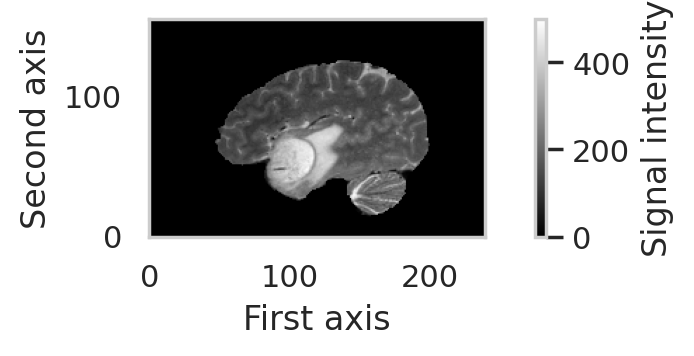

In [12]:
# visualize the slices over the first, second and third dimensions.
# calculate the value of the first, second and third dimensions
n_i, n_j, n_k = img_data.shape

# first dimension
i = (n_j - 1) // 2

# second dimension
j = (n_j - 1) // 2

# third dimension
k = (n_k - 1) // 2

print(f"The value the first, second and third dimensions are {i}, {j} and {k}")

# Visualize the first slice
mid_slice_1 = img_data[i, :, :]

mid_slice_2 = img_data[j, :, :]


mid_slice_3 = img_data[k, :, :]


mid_slice_list = [mid_slice_1, mid_slice_2, mid_slice_3]

for k in range(len(mid_slice_list)):
  plt.subplot(3, 1, k+1)
  plt.imshow(mid_slice_list[k].T, cmap='gray', origin='lower')
  plt.xlabel('First axis')
  plt.ylabel('Second axis')
  plt.colorbar(label='Signal intensity')
  plt.show()

# Excersice 2: Preprocessing MRI with TorchIO: Spatial Transformations

[TorchIO](https://torchio.readthedocs.io) is an open-source Python library for efficient loading, preprocessing, augmentation and patch-based sampling of 3D medical images in deep learning, following the design of PyTorch.

Load the dataset from TorchIO and display them.


Sample subject: FPG(Keys: ('t1', 'seg', 't2', 'fmri', 'dmri'); images: 5)
ScalarImage(shape: (1, 256, 256, 176); spacing: (1.00, 1.00, 1.00); orientation: PIR+; path: "/root/.cache/torchio/fpg/t1.nii.gz")
ScalarImage(shape: (1, 320, 320, 26); spacing: (0.75, 0.75, 5.50); orientation: LAS+; path: "/root/.cache/torchio/fpg/t2.nii.gz")


<ipython-input-4-9ae52b1be796>:102: UserWarning: Image orientation should be RAS+, not PIR+
  warnings.warn(f'Image orientation should be RAS+, not {orientation}+')


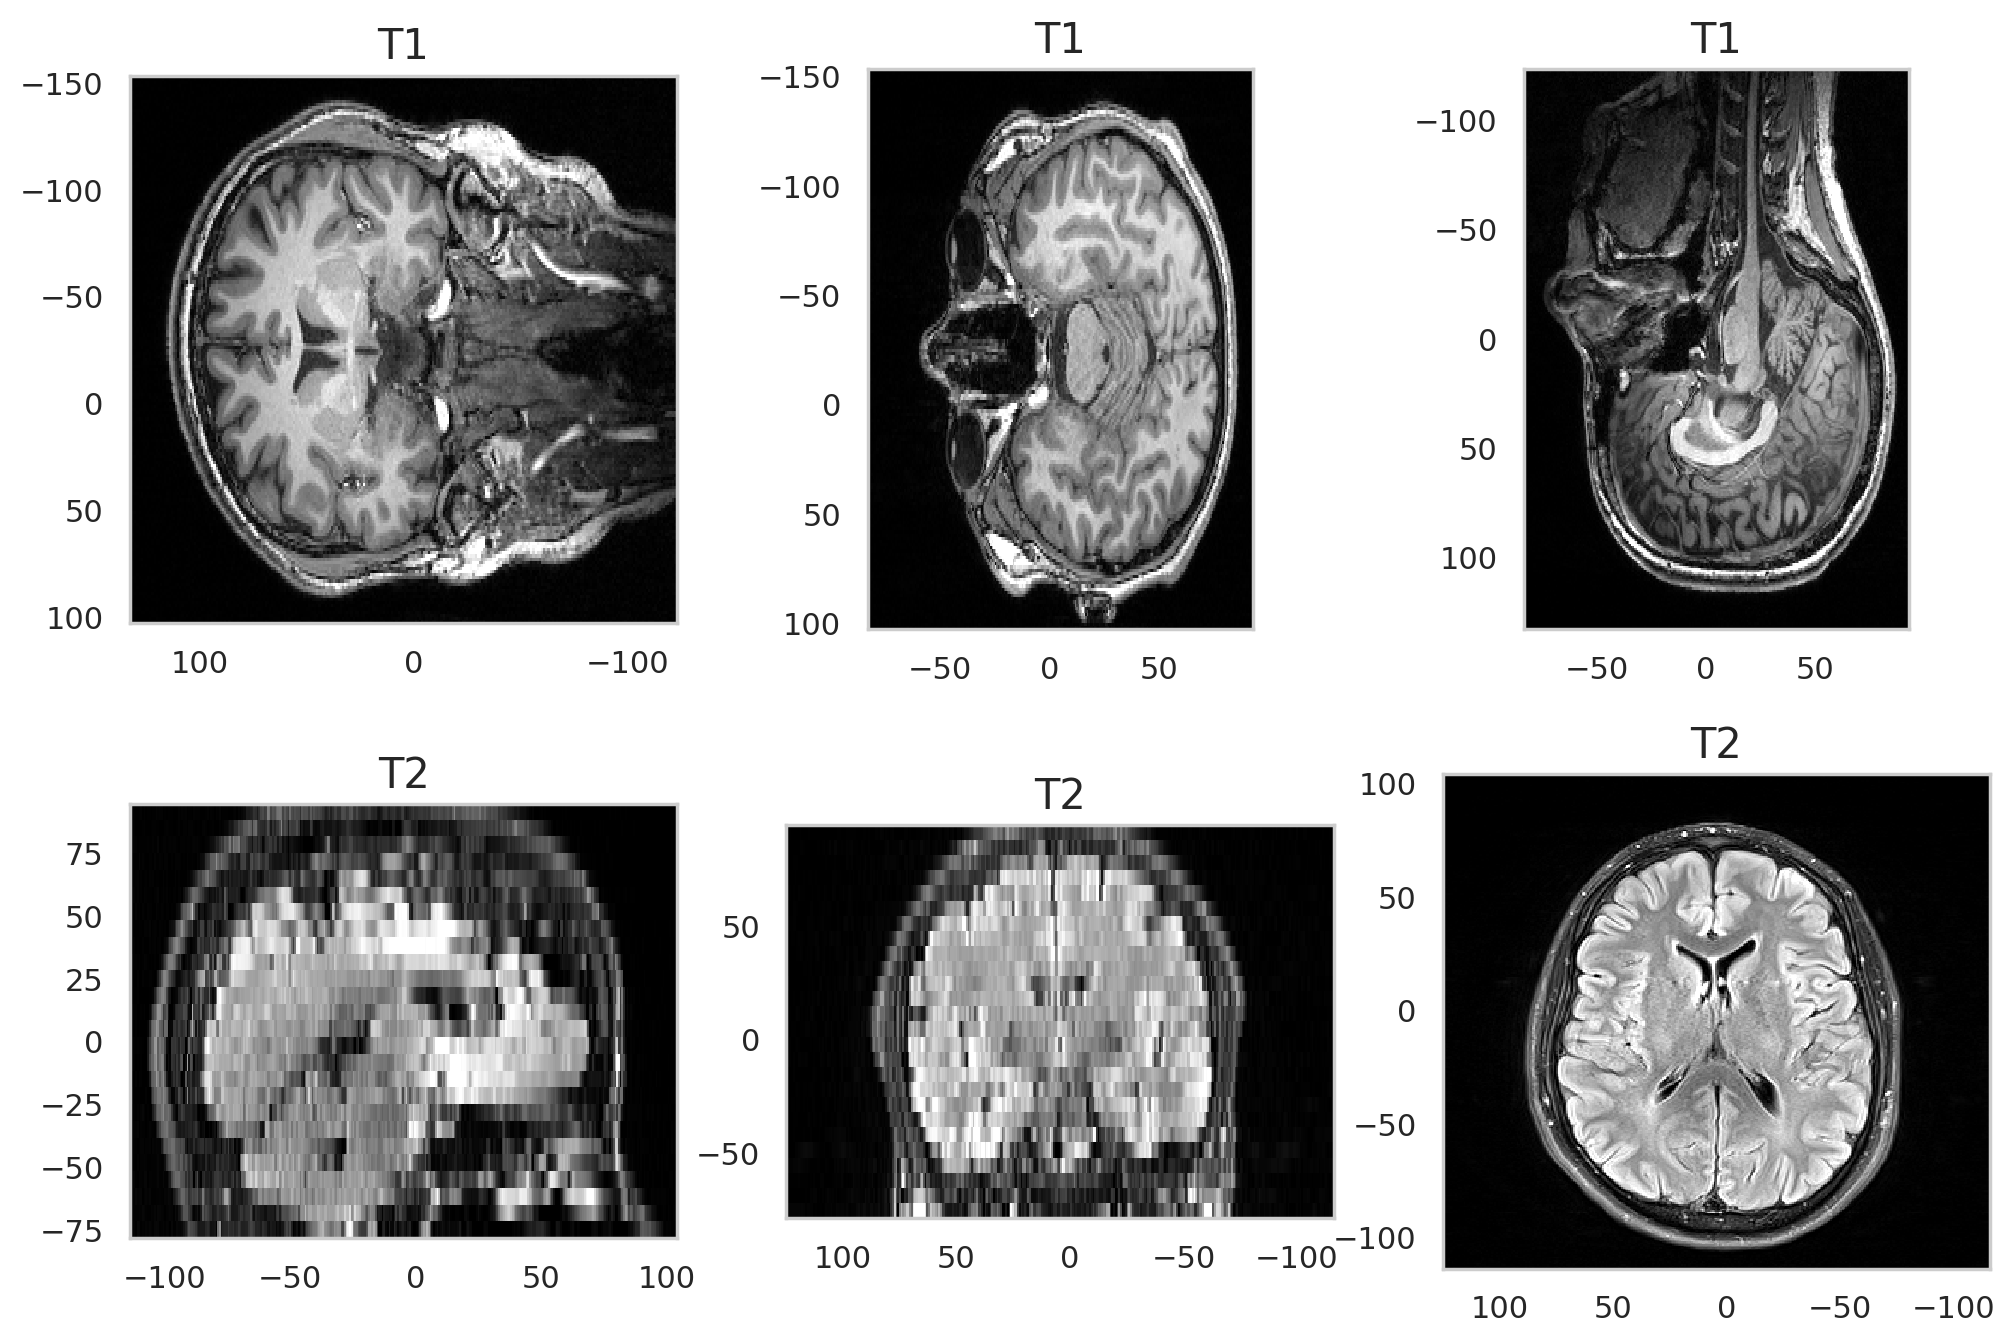

In [5]:
fpg = tio.datasets.FPG(load_all = True)
print('Sample subject:', fpg)
print(fpg.t1)
print(fpg.t2)

show_fpg(fpg)

## Your tasks:
1. Fix the orientation of the images. Use the canonical transformation to ensure consistent orientation across our dataset.
2. Fix the spacing by putting our dataset in the same standard space (the MNI space)
3. Crop or pad the images to the `target_shape = 150, 190, 170`
4. If the dataset is too heavy you can always downsample. You can make your code to run faster but the resolution of your images is decreased. Try downsapling by 5 and then by 2. Comment on the difference you see.

T1w old orientation: ('P', 'I', 'R')
T1w new orientation ('R', 'A', 'S')
T1w old orientation: ('L', 'A', 'S')
T1w new orientation ('R', 'A', 'S')


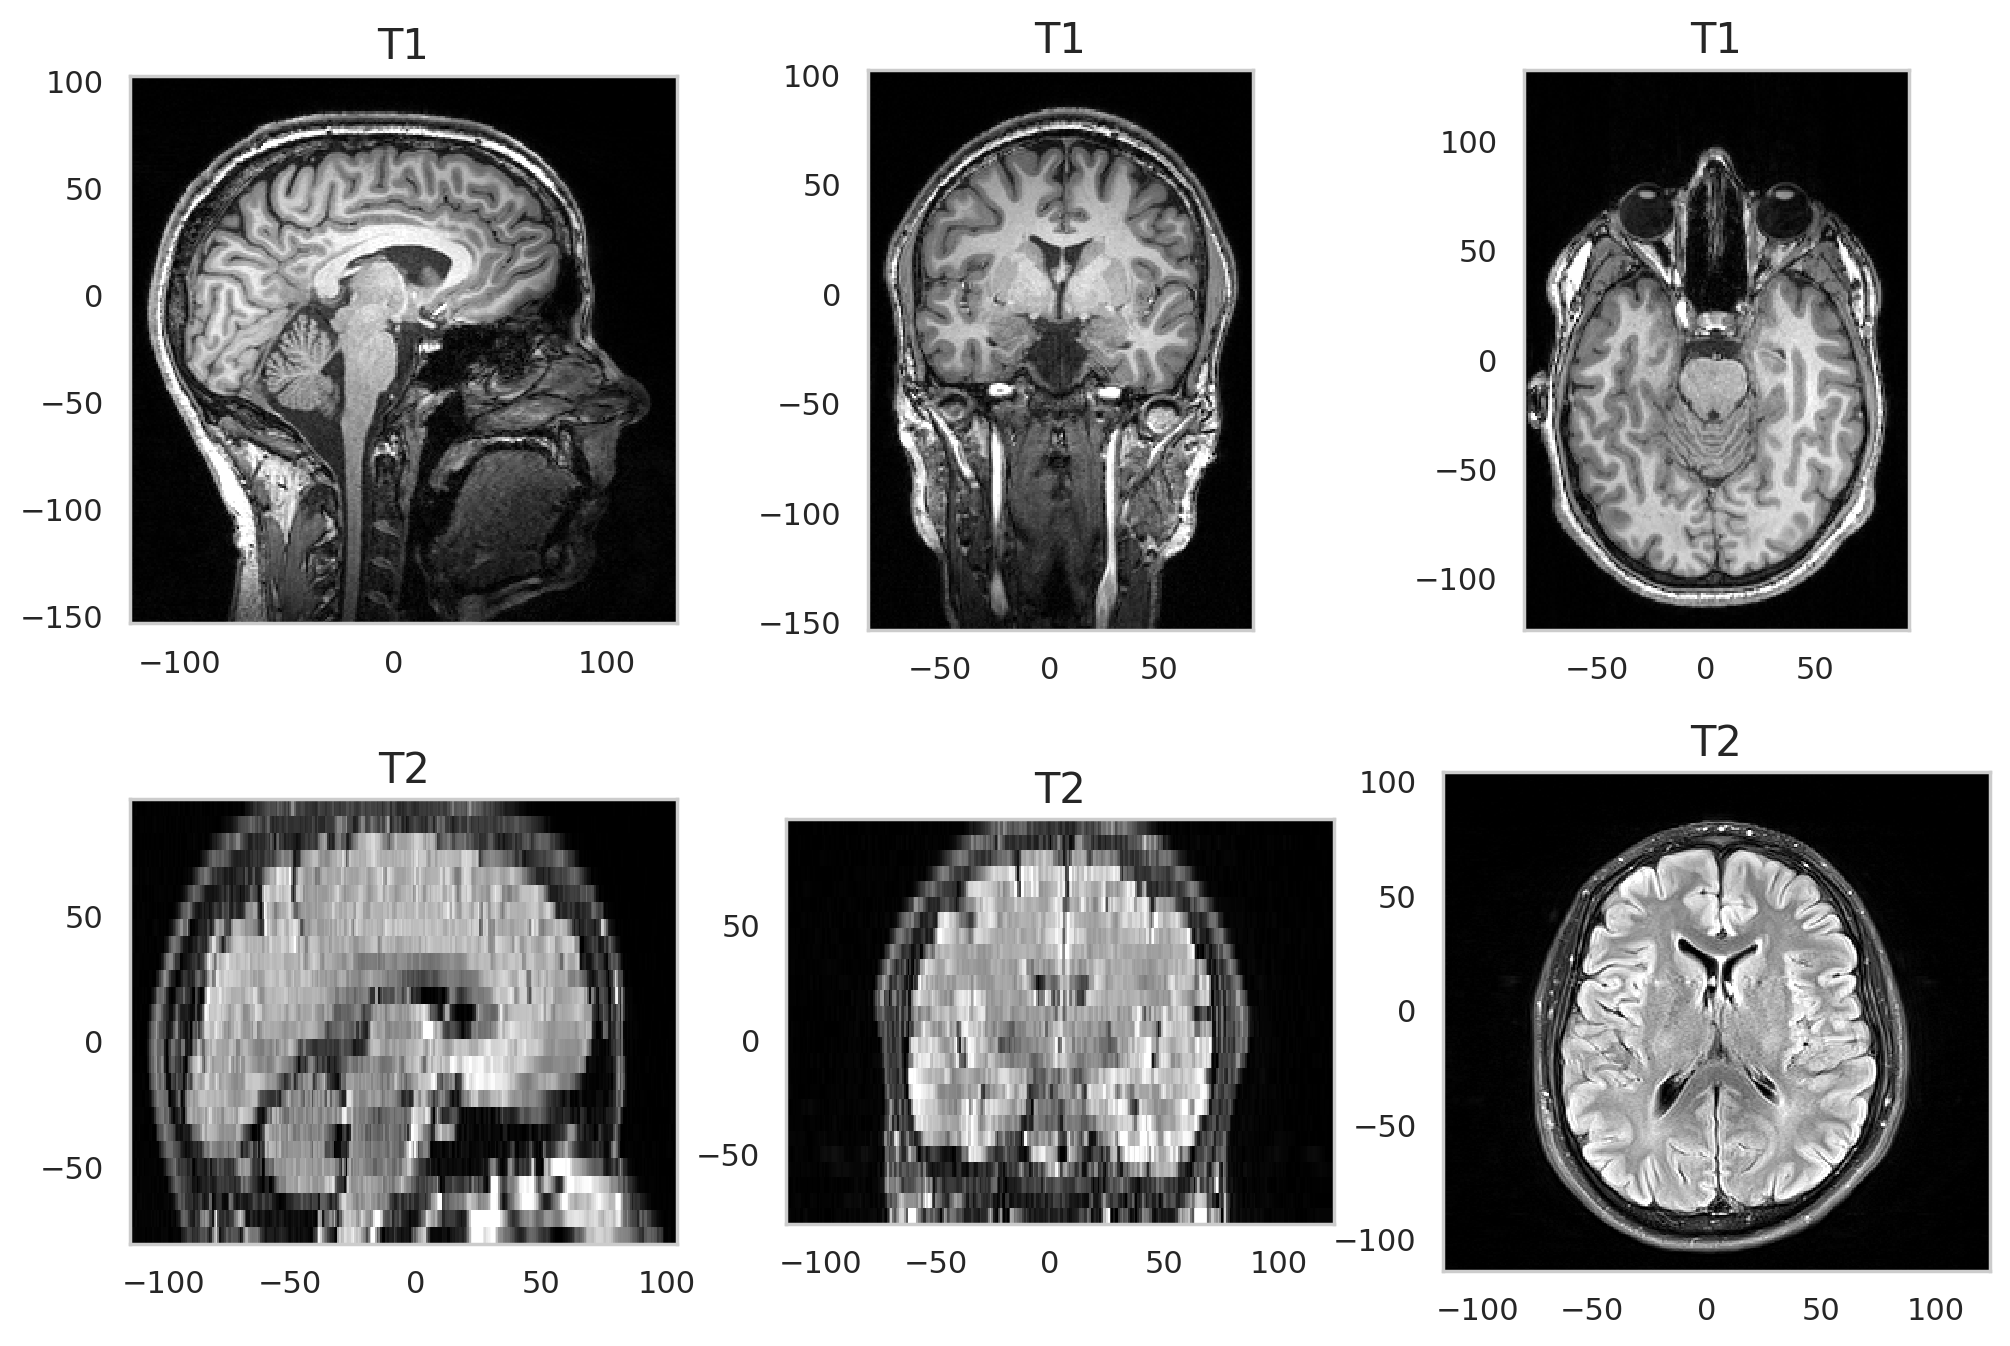

In [6]:
# Type your code here
# load the image
to_ras = tio.ToCanonical()
fpg_ras = to_ras(fpg)
print("T1w old orientation:", fpg.t1.orientation)
print("T1w new orientation", fpg_ras.t1.orientation)
print("T1w old orientation:", fpg.t2.orientation)
print("T1w new orientation", fpg_ras.t2.orientation)

show_fpg(fpg_ras)

In [15]:
# fix the spacing 
to_mni = tio.Resample(mni.t1.path, pre_affine_name = "affine_matrix")
fpg_mni = to_mni(fpg_ras)

In [16]:
# crop the image 
target_shape = 150, 190, 170
crop_pad = tio.CropOrPad(target_shape)
fpg_crop = crop_pad(fpg_mni)

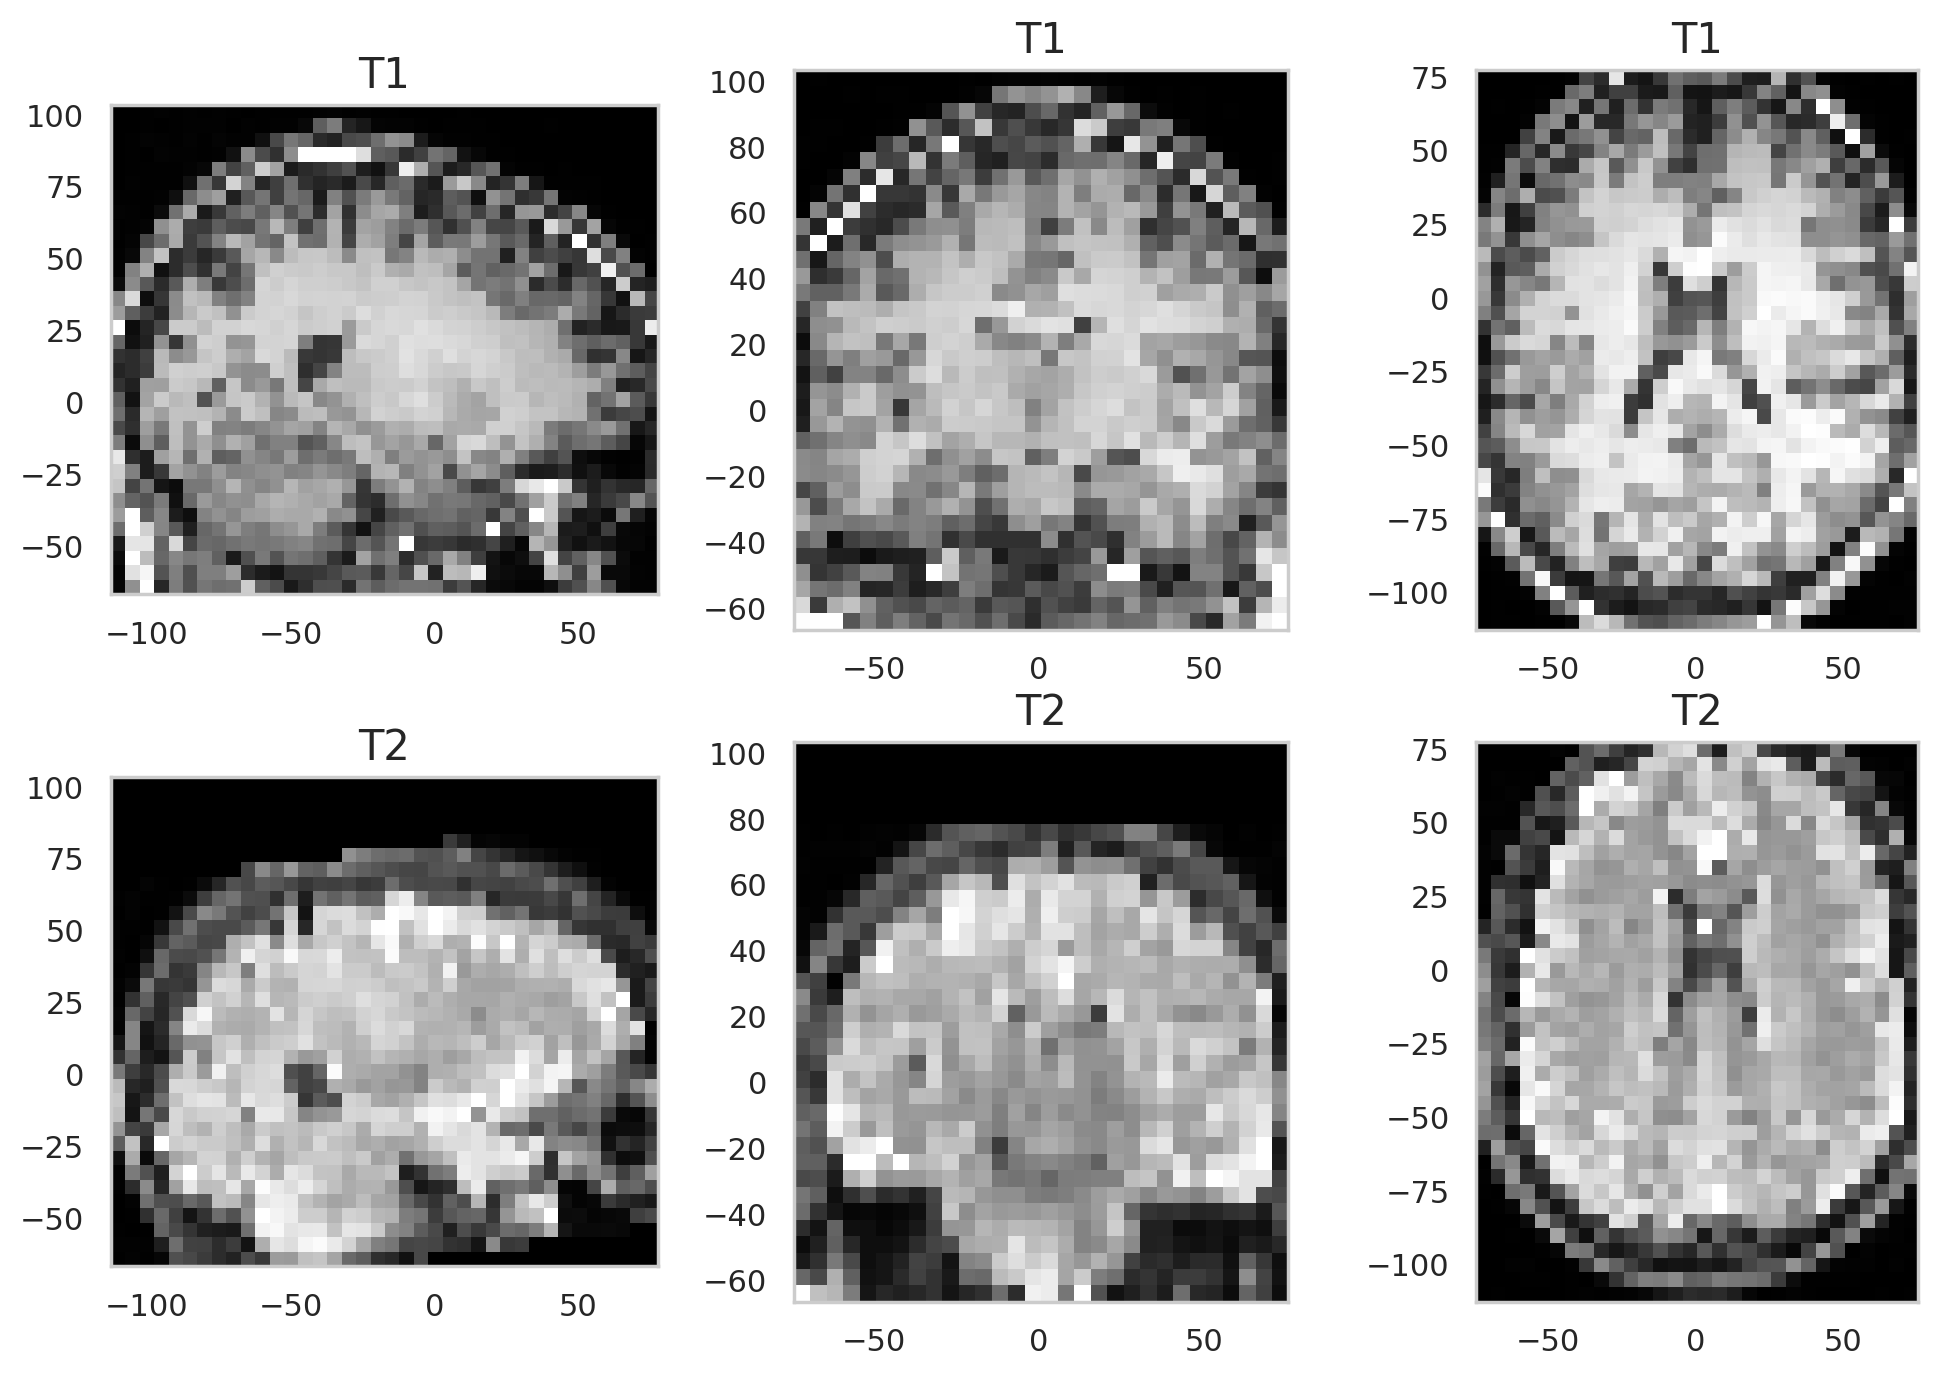

In [17]:
# Downsample the image by a factor of 5
downsampling_factor = 5
original_spacing = 1
target_spacing = downsampling_factor / original_spacing
downsample = tio.Resample(target_spacing)
downsampled  = downsample(fpg_crop)
show_fpg(downsampled)

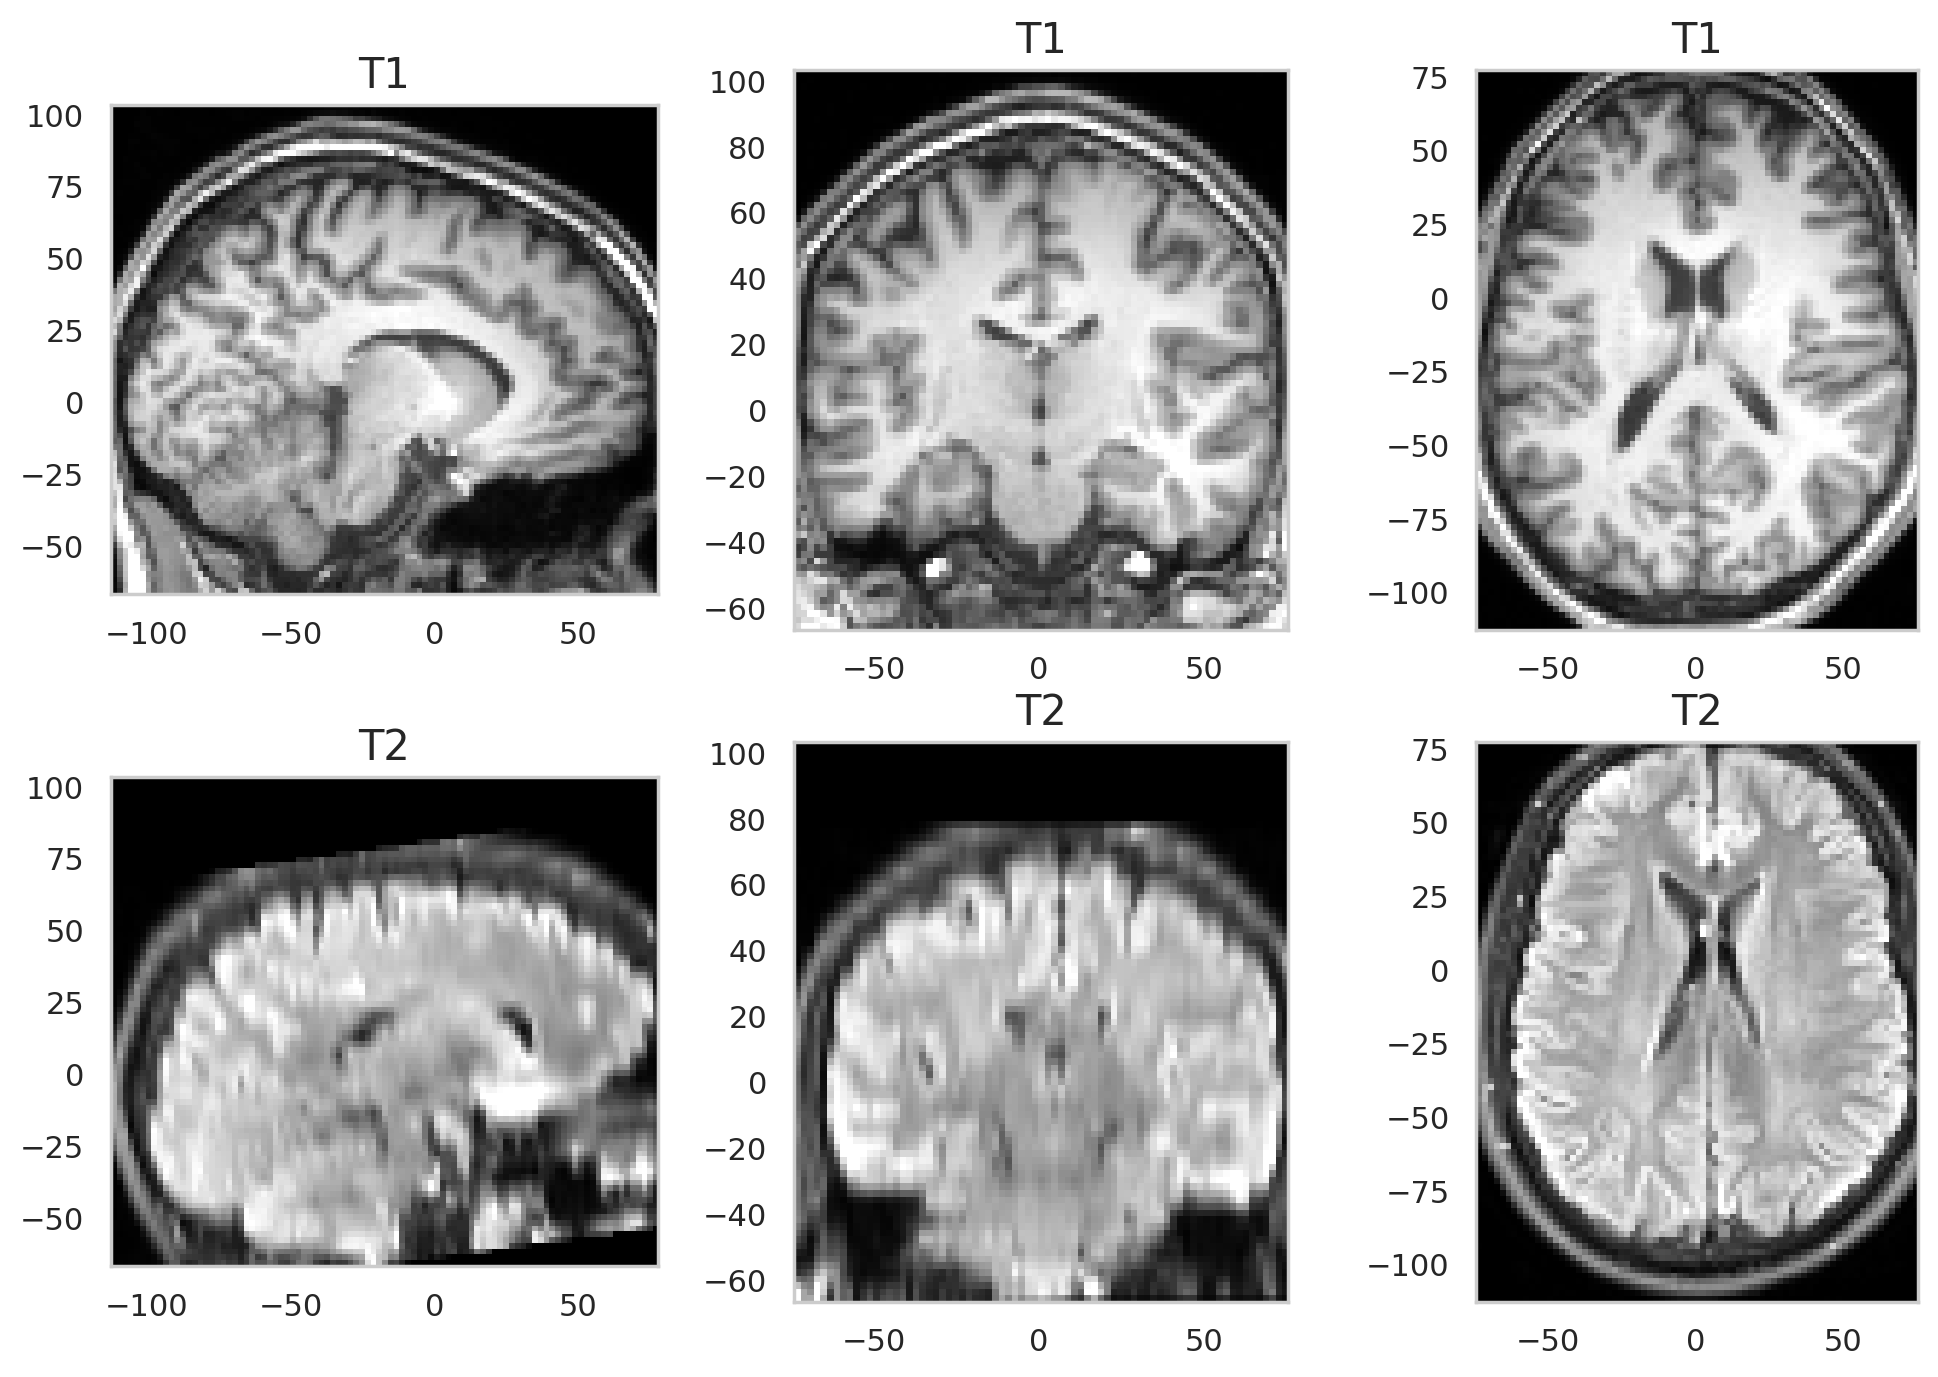

In [18]:
# Downsample the image by a factor of 2
downsampling_factor = 2
original_spacing = 1
target_spacing = downsampling_factor / original_spacing
downsample = tio.Resample(target_spacing)
downsampled  = downsample(fpg_crop)
show_fpg(downsampled)

The downsampling factor affects the images.
It can been in two images that choosing a downsampling of 5 degrade the image quality as compared to the 2.
Thus, the higher the downsampling the more the quality of the image is degraded. Thus more aliasing is introduced in it.

# Excersice 3: Preprocessing MRI with TorchIO: Data Augmentation

Data augmentation helps increase the number of data images we can feed the model and helps the model generalize.

## Your tasks:
1. Add random anisotropy to our dataset and visualize it
2. Add random affine to our dataset and visualize it
3. Add random flip along the anterior-posterior axis with probability = 0.5 to our dataset and visualize it
4. Add random elastic deformation with `max_displacement = 10, 20, 15` to our dataset and visualize it

Applied transforms:
[ToCanonical(),
 Resample(target=/root/.cache/torchio/mni_colin27_1998_nifti/colin27_t1_tal_lin.nii.gz, image_interpolation=linear, pre_affine_name=affine_matrix, scalars_only=False),
 Crop(cropping=(16, 15, 14, 13, 6, 5)),
 Resample(target=2.0, image_interpolation=linear, pre_affine_name=None, scalars_only=False),
 Resample(target=(2.0, 5.949212551116943, 2.0), image_interpolation=nearest, pre_affine_name=None, scalars_only=True),
 Resample(target=((75, 95, 85), array([[   2. ,    0. ,    0. ,  -73.5],
       [   0. ,    2. ,    0. , -111.5],
       [   0. ,    0. ,    2. ,  -65.5],
       [   0. ,    0. ,    0. ,    1. ]])), image_interpolation=linear, pre_affine_name=None, scalars_only=True)]


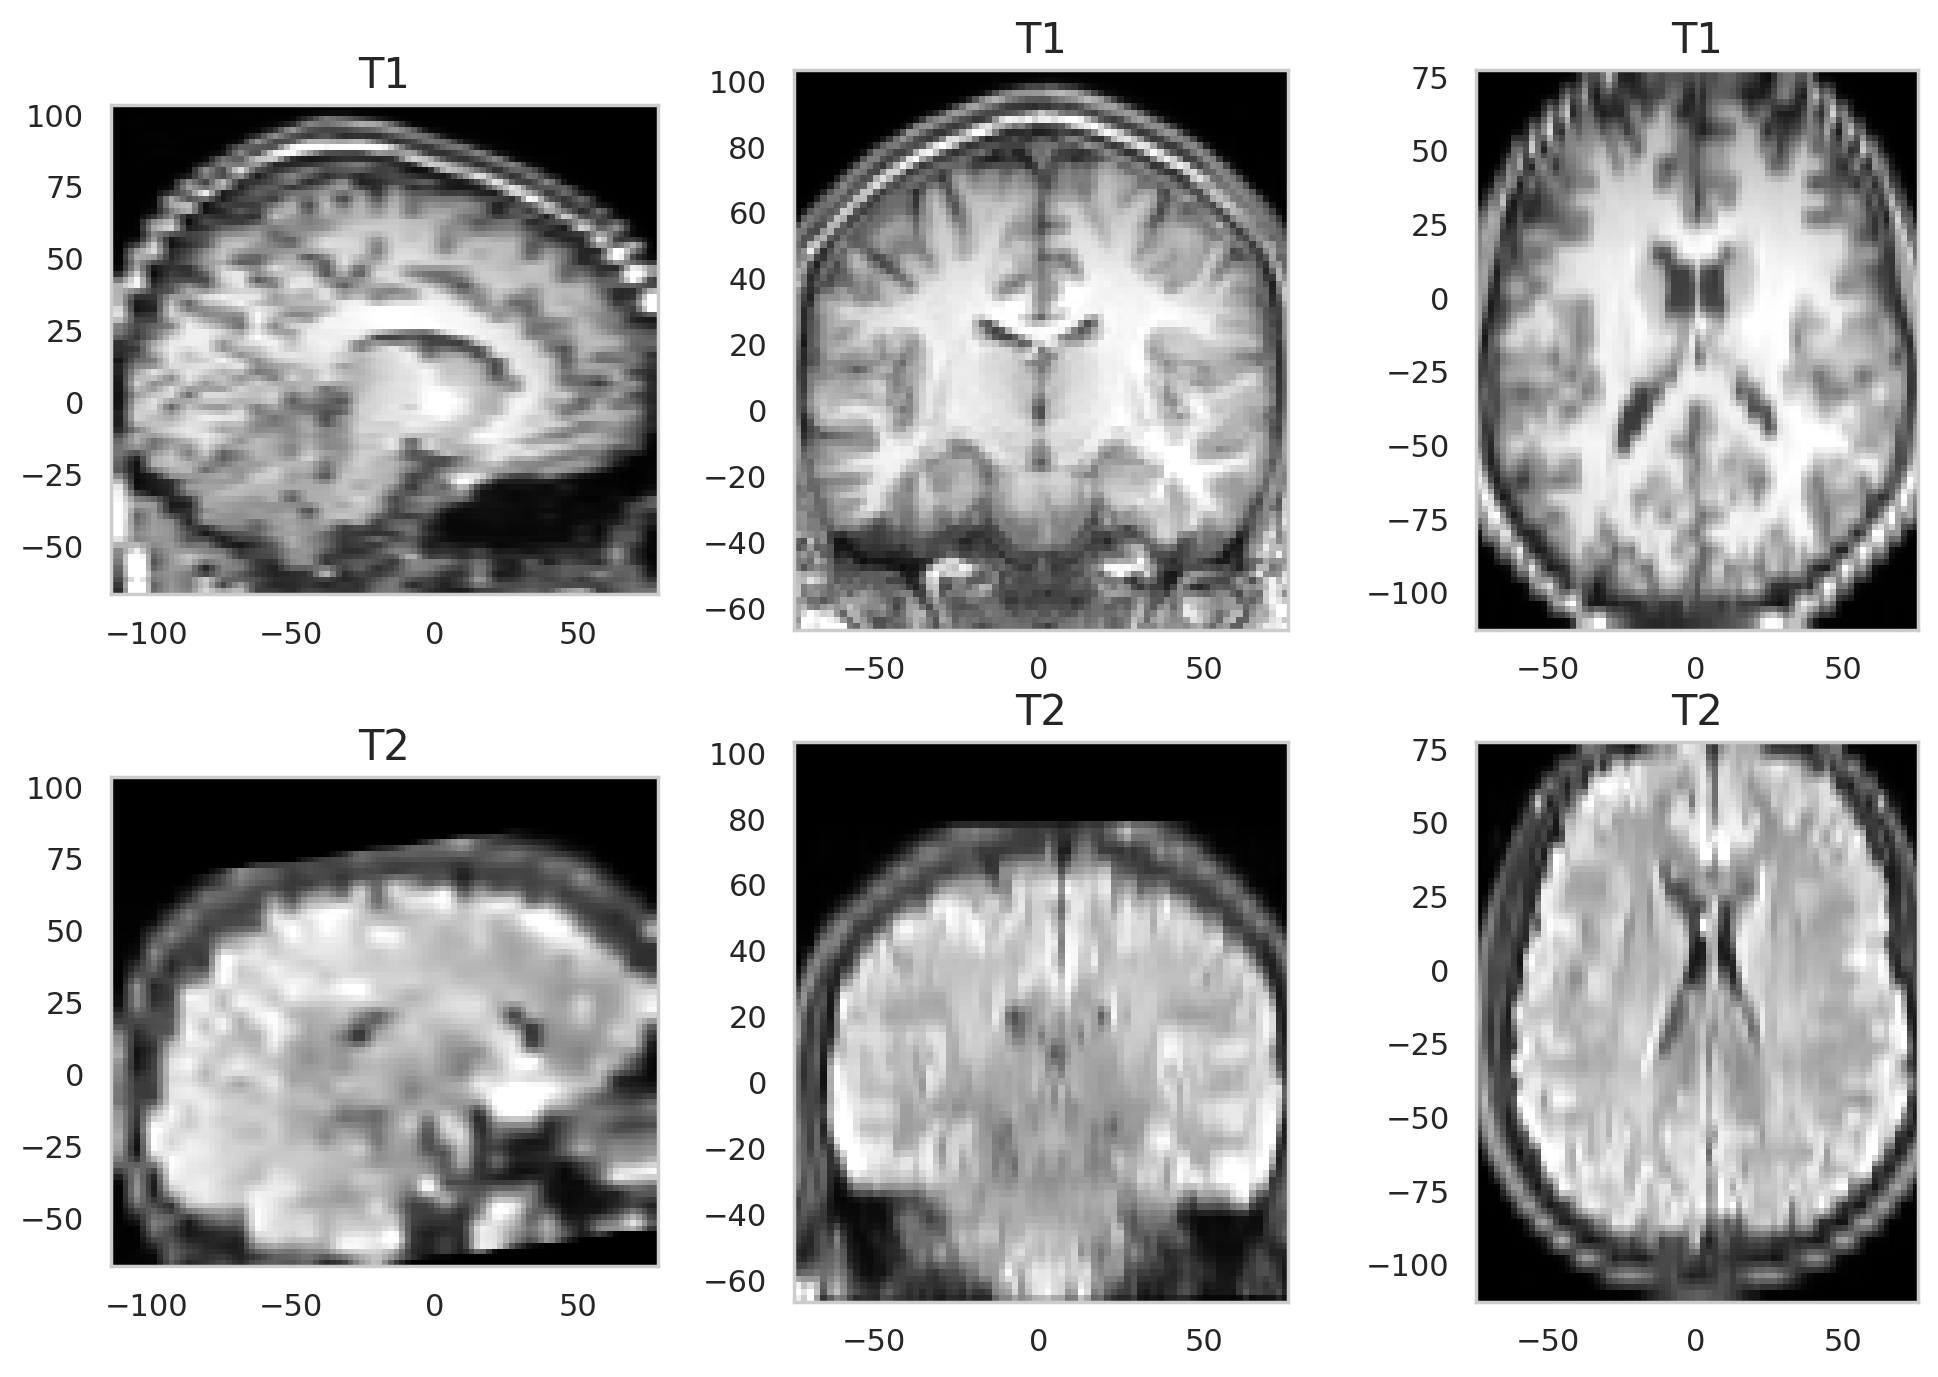

In [19]:
# Type your code here
random_anisotropy = tio.RandomAnisotropy()

fpg_anisotropic = random_anisotropy(downsampled)
print("Applied transforms:")
pprint.pprint(fpg_anisotropic.history)
show_fpg(fpg_anisotropic)

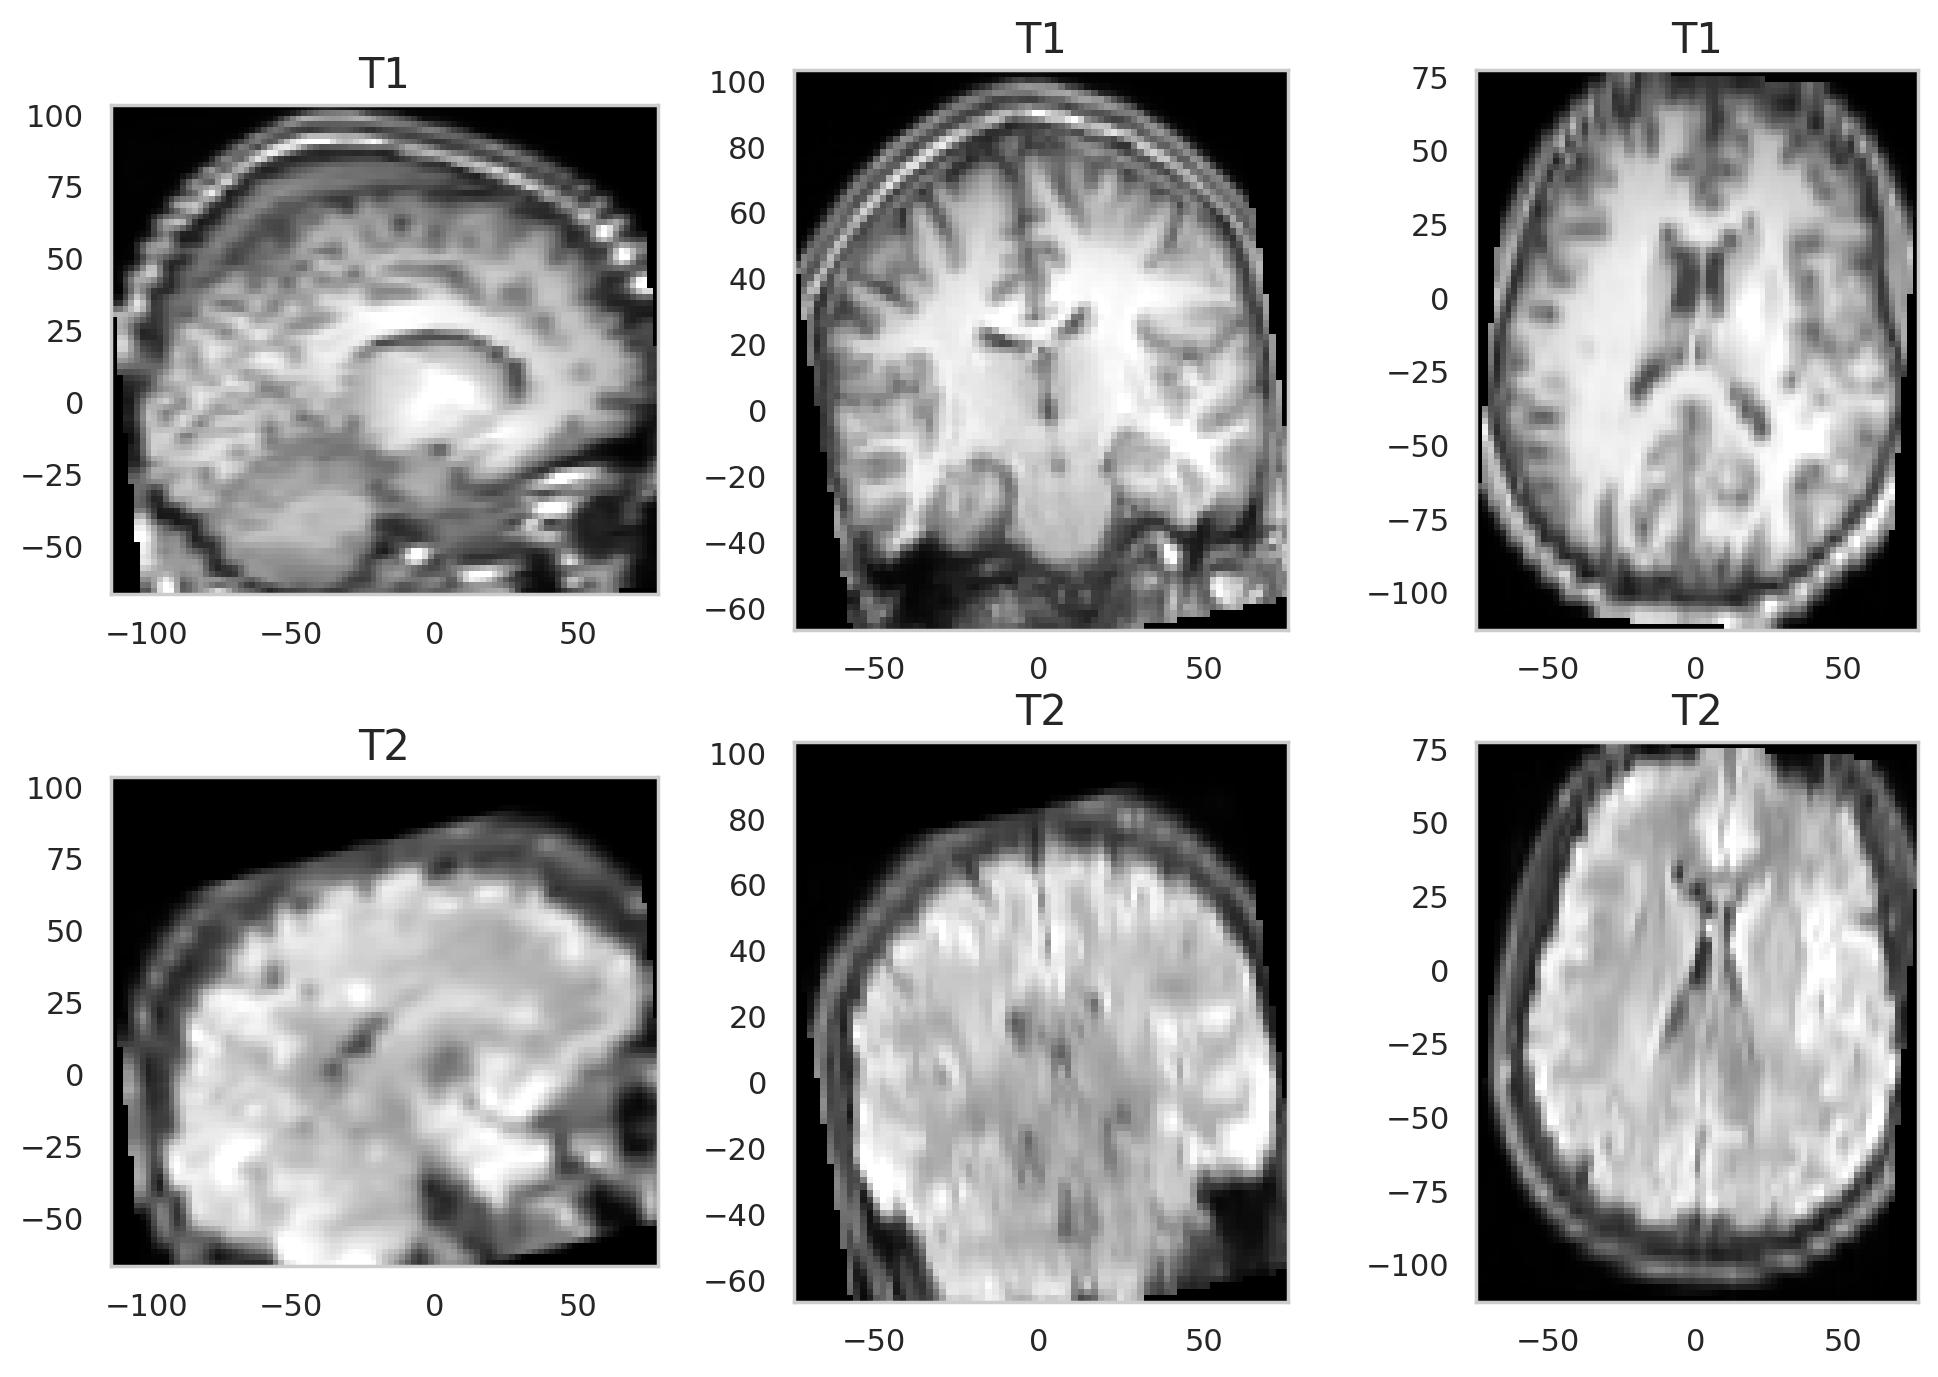

In [20]:

# apply RandomAffine
random_affine = tio.RandomAffine()
ras_fpg_affine = random_affine(fpg_anisotropic)
show_fpg(ras_fpg_affine)

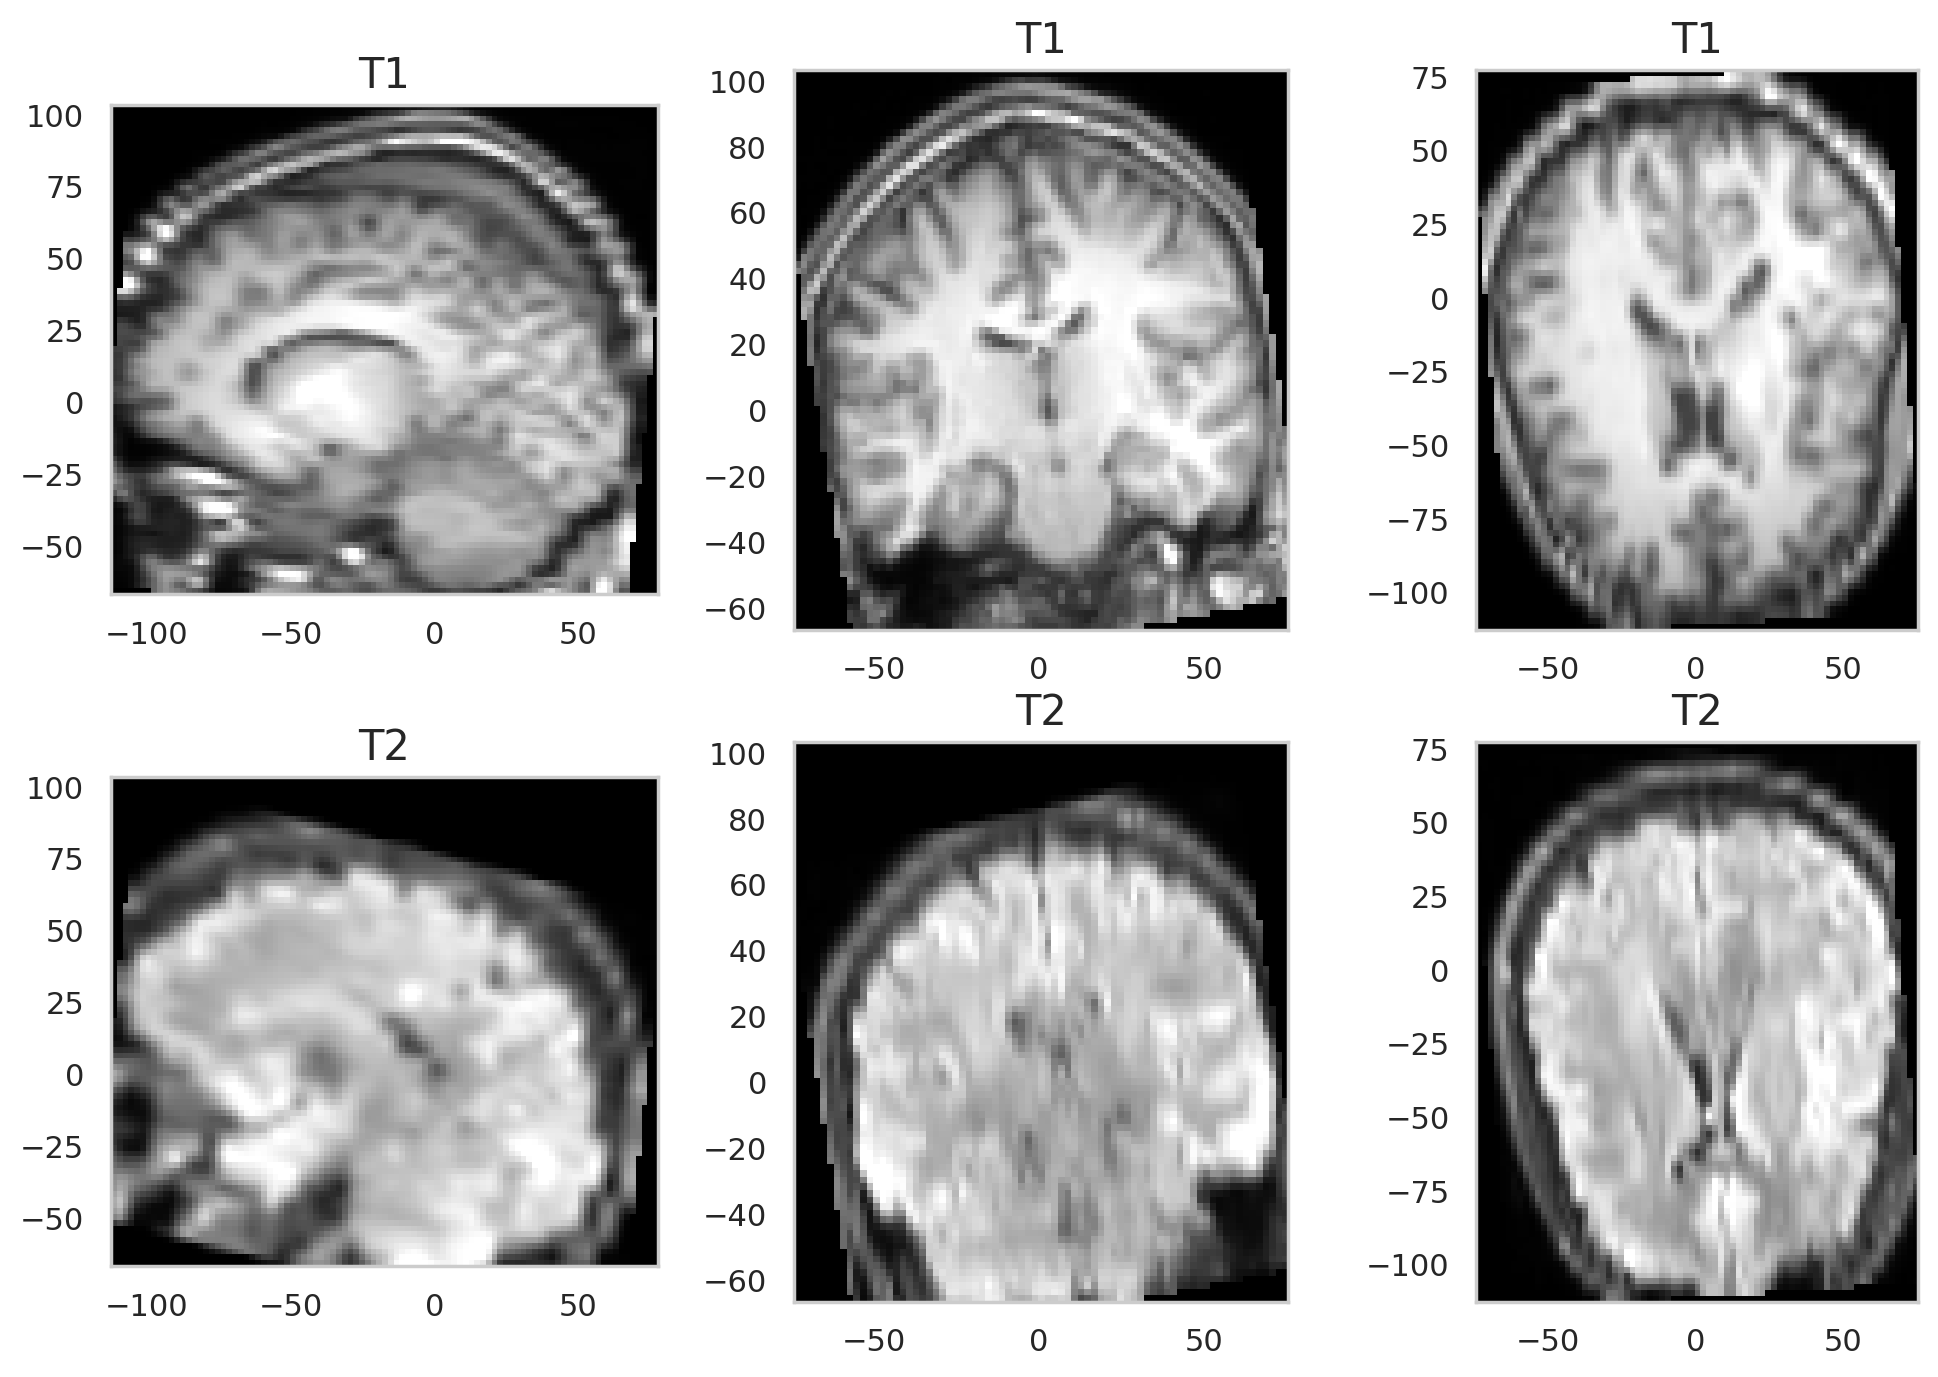

In [21]:
# flip the dataset along the anterior-posterior with probability of 0.5
random_flip = tio.RandomFlip(axes = ['anterior-posterior'], flip_probability=0.5)
ras_fpg_flip = random_flip(ras_fpg_affine)
show_fpg(ras_fpg_flip)

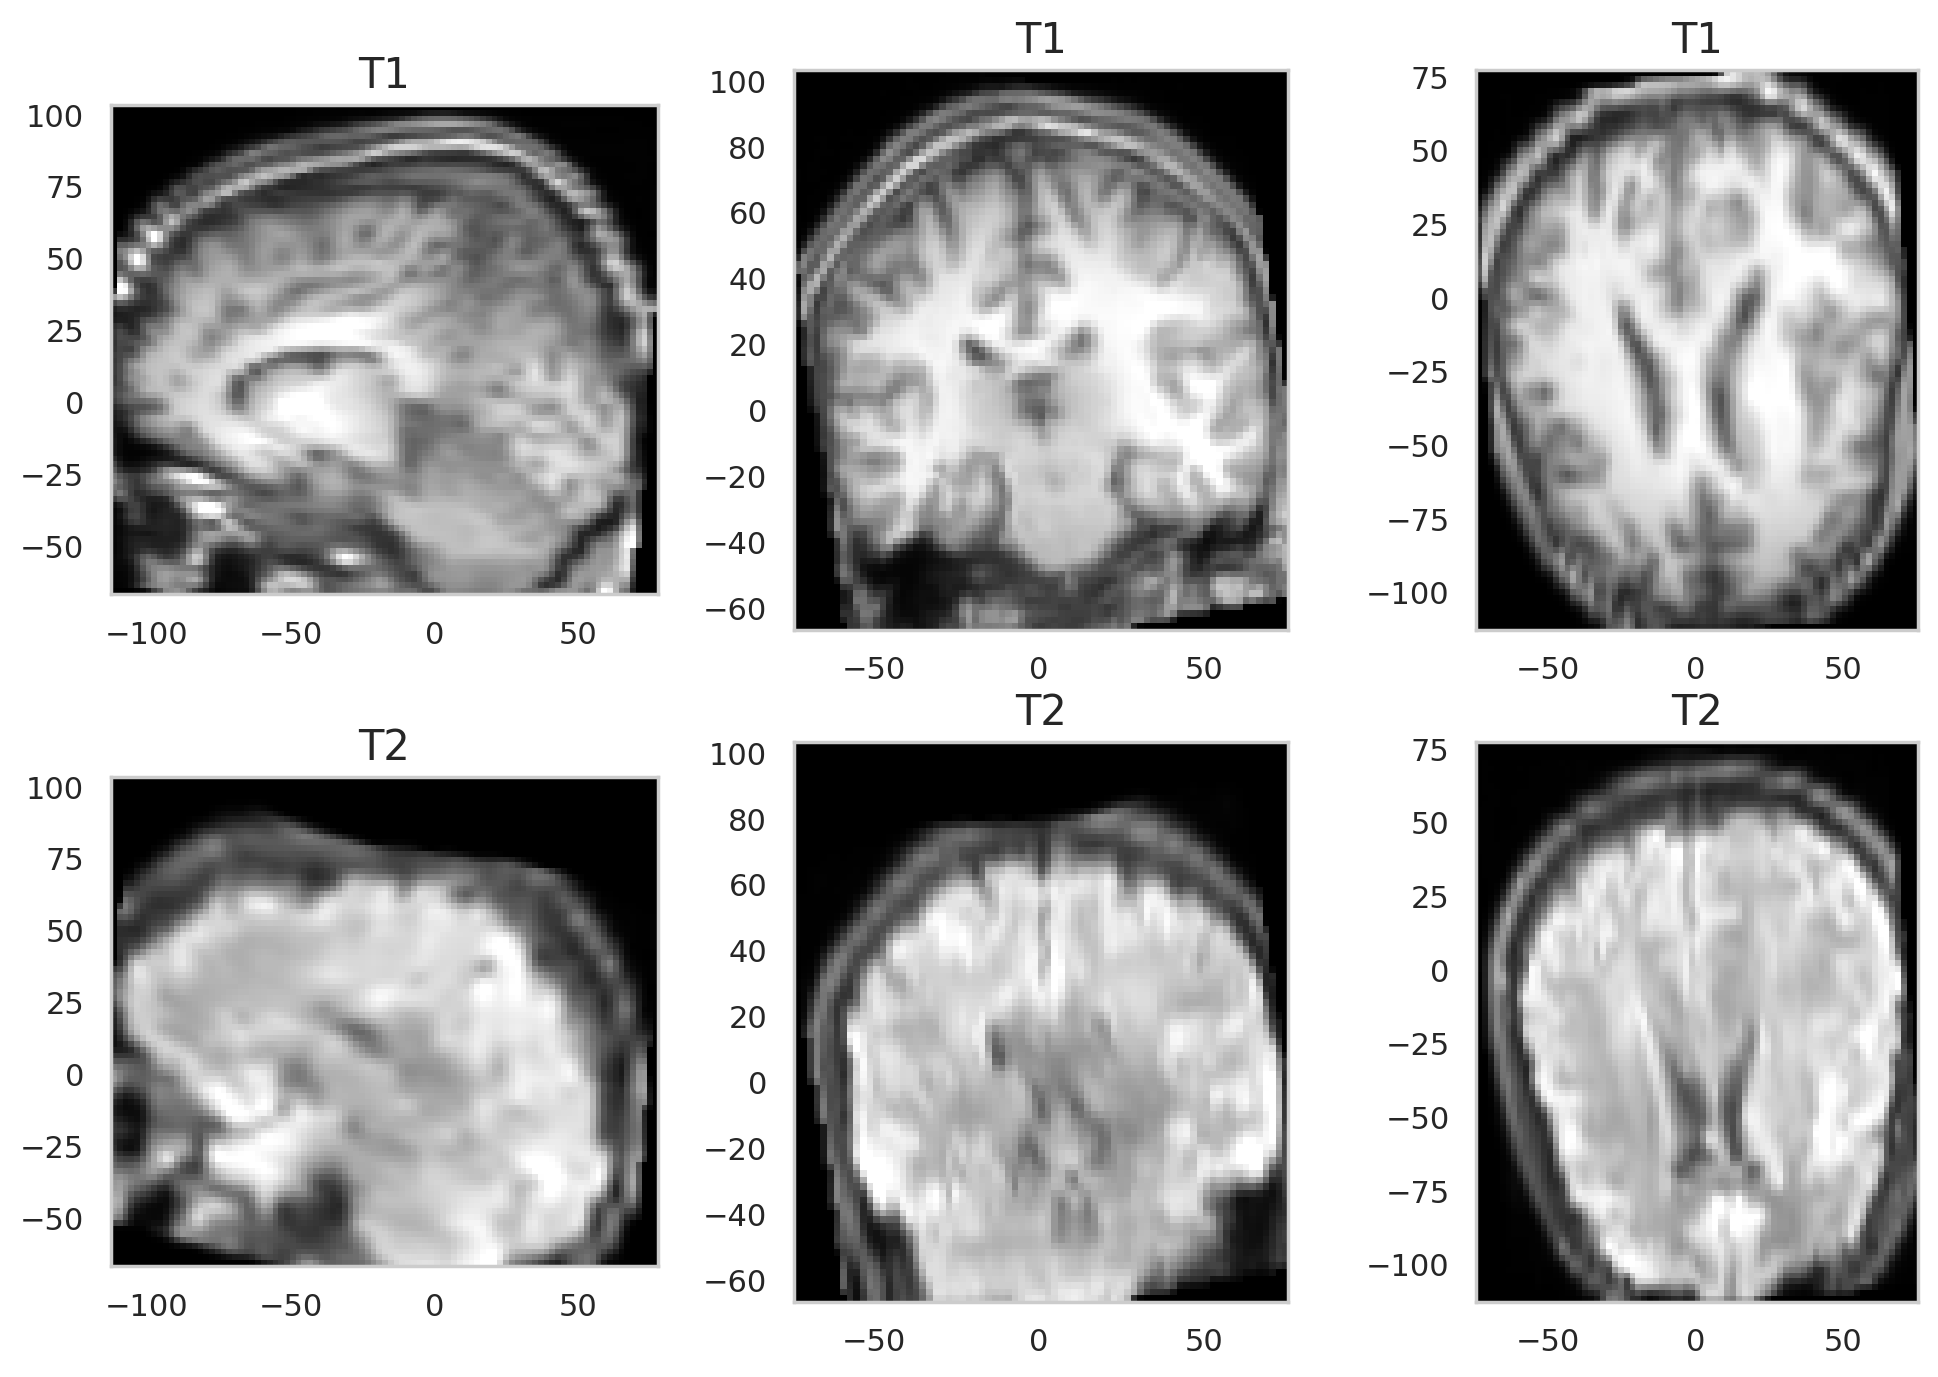

In [24]:
# add random elastic deformation with max_displacement = 10, 20, 15
max_displacement = 10, 20, 15
random_elastic = tio.RandomElasticDeformation(max_displacement = max_displacement)
fpg_random_elastic = random_elastic(ras_fpg_flip)
show_fpg(fpg_random_elastic)

# Excersice 4: Preprocessing MRI with TorchIO: Intensity Transforms

## Your tasks:
1. Rescale the intensity of our dataset to the range (0,1) and ignore all pixel values outside the 1% and 99% percentiles. Visualize it
2. Add random blur to our dataset and visualize it
3. Add random noise to our dataset and visualize it
4. Add k-space transformations to our dataset including random spike, random ghosting, and random motion, and visualize them

<ipython-input-25-f455e97c5122>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(fpg.t1.data, ax = axes[0], kde = False)
<ipython-input-25-f455e97c5122>:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(fpg_rescaled.t1.data, ax = axes[1], kde = False)


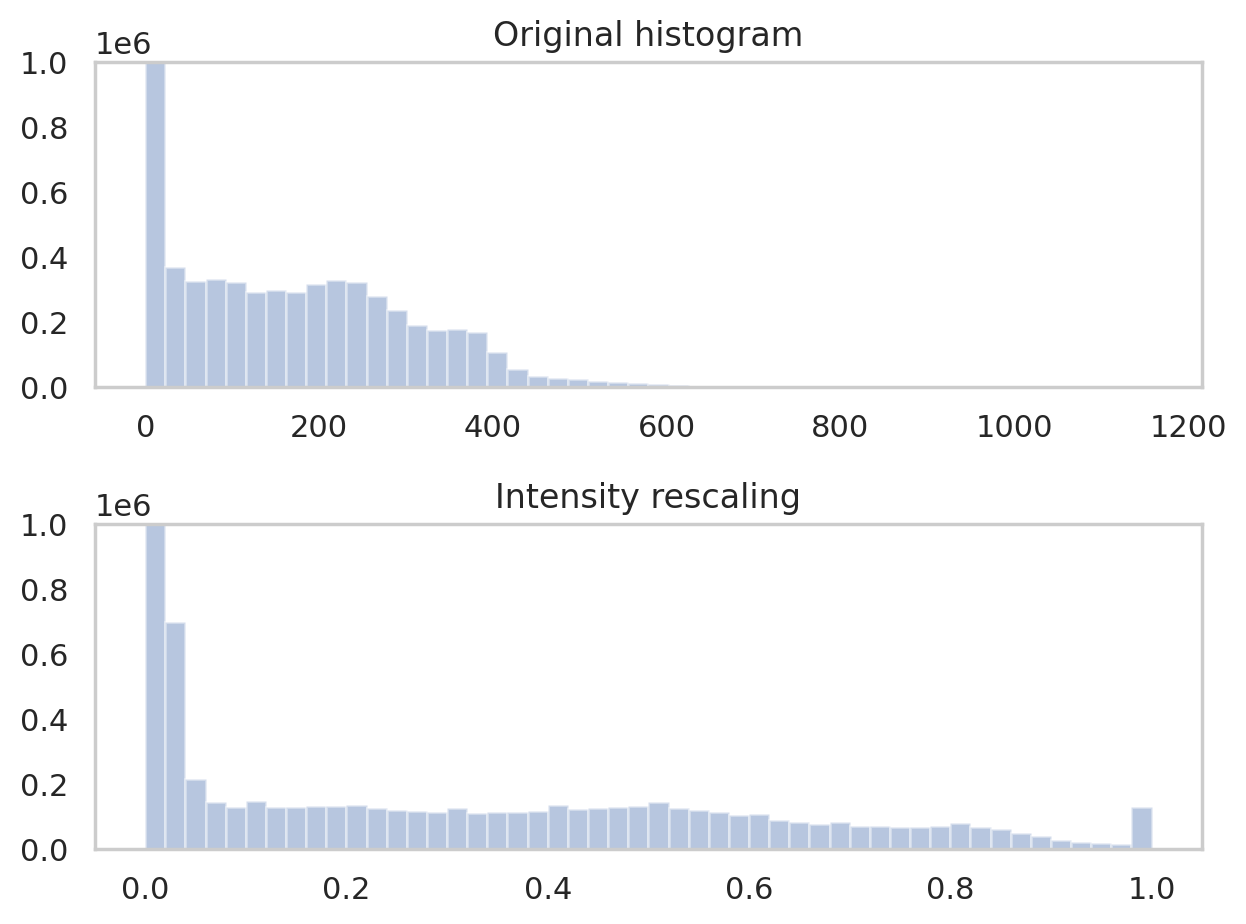

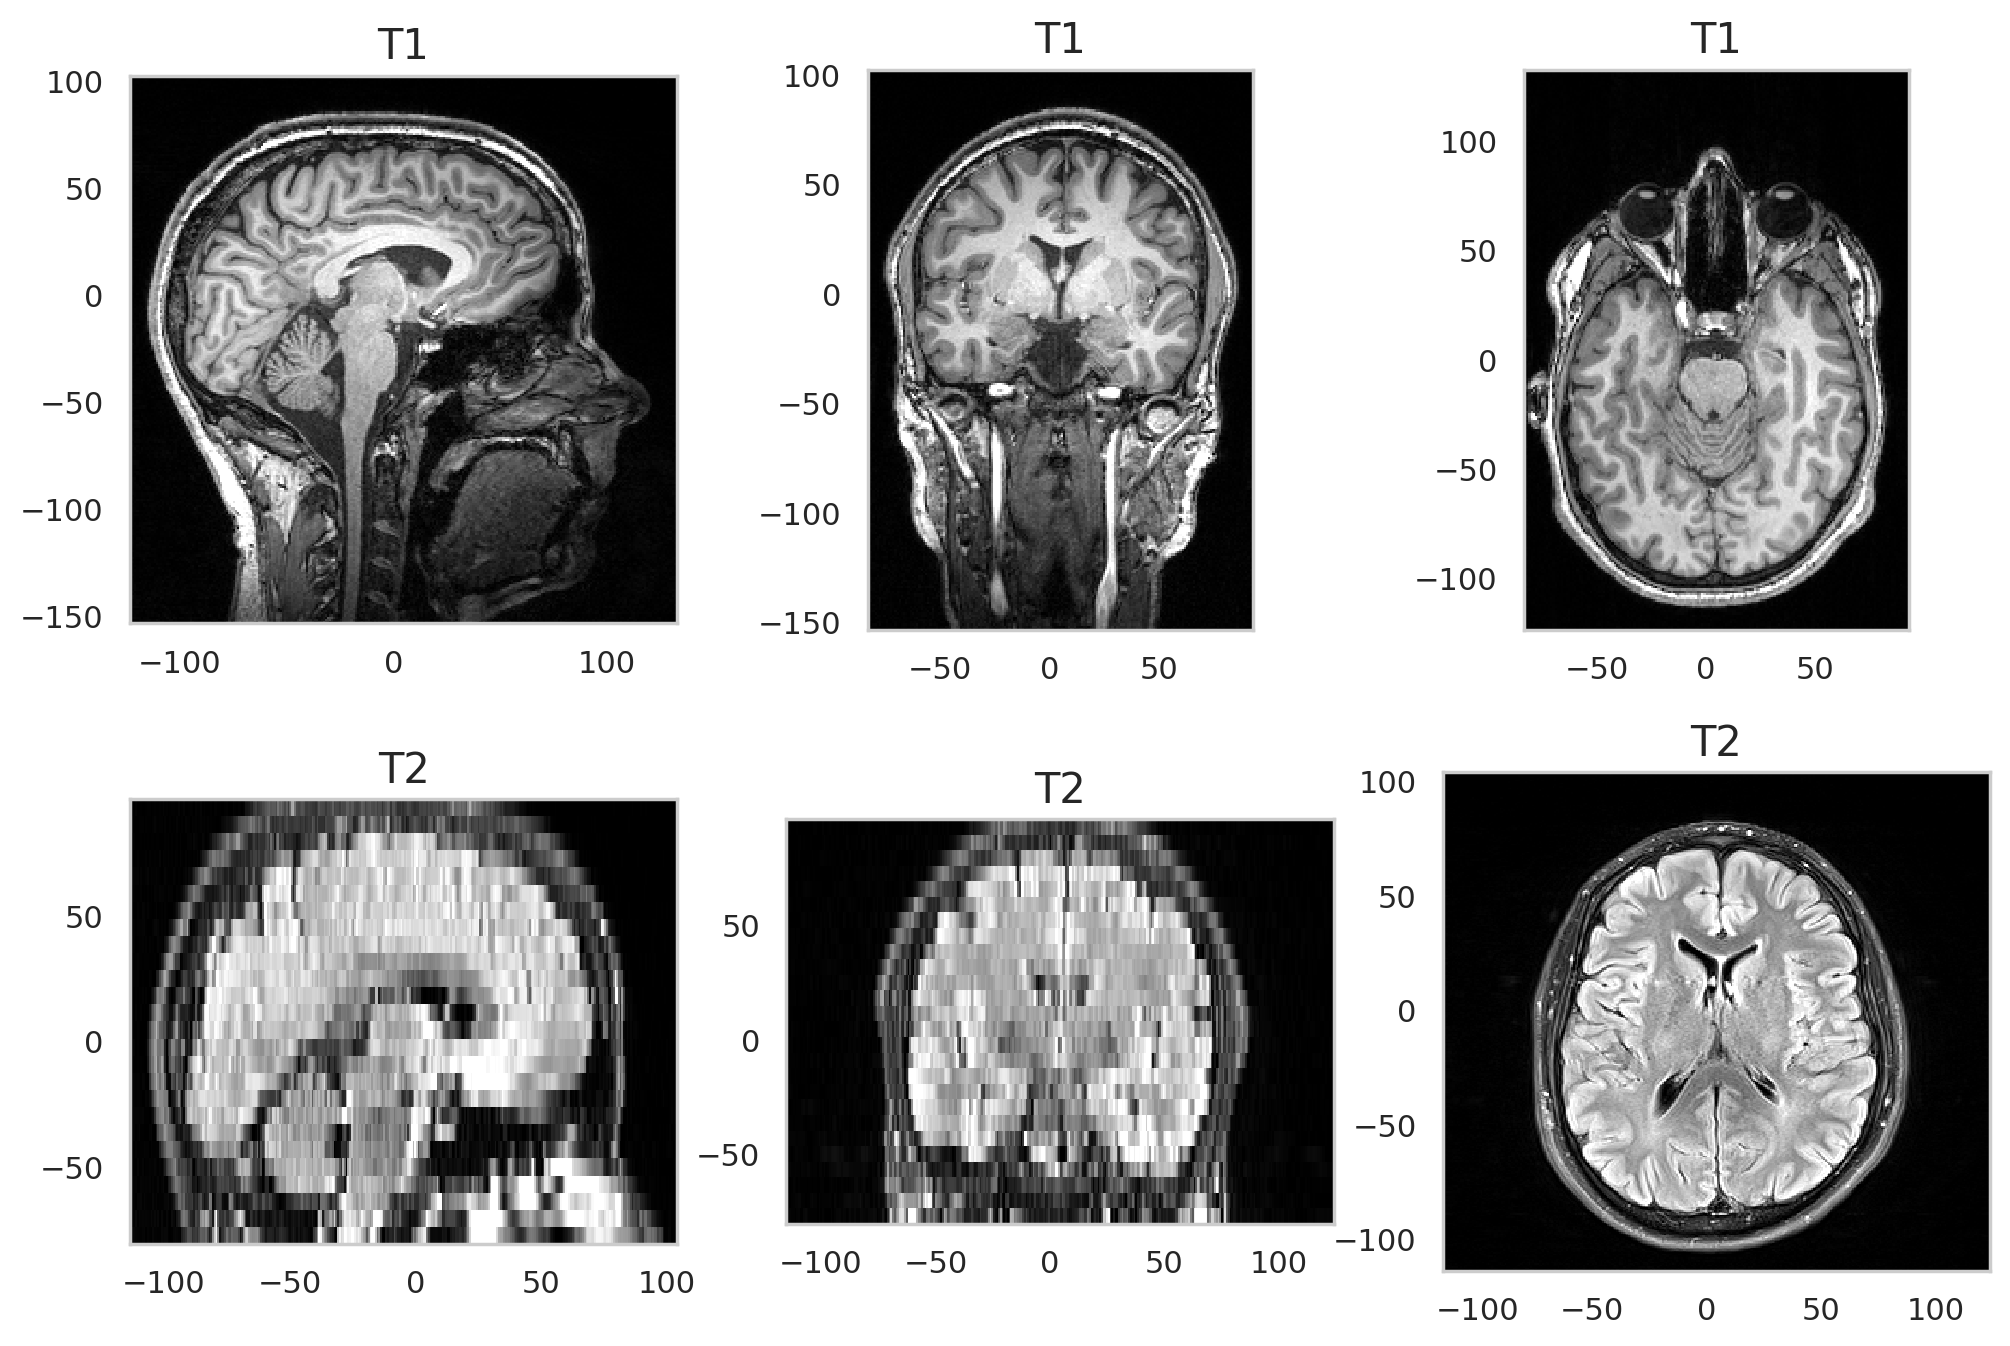

In [25]:
# Type your code here
# rescale the intensities in to the range(0,1)
rescale = tio.RescaleIntensity((0, 1), percentiles = (1, 99))
fpg_rescaled = rescale(fpg_ras)
fig, axes = plt.subplots(2, 1)
sns.distplot(fpg.t1.data, ax = axes[0], kde = False)
sns.distplot(fpg_rescaled.t1.data, ax = axes[1], kde = False)
axes[0].set_title("Original histogram")
axes[1].set_title("Intensity rescaling")
axes[0].set_ylim((0, 1e6))
axes[1].set_ylim((0, 1e6))
plt.tight_layout()
show_fpg(fpg_rescaled)


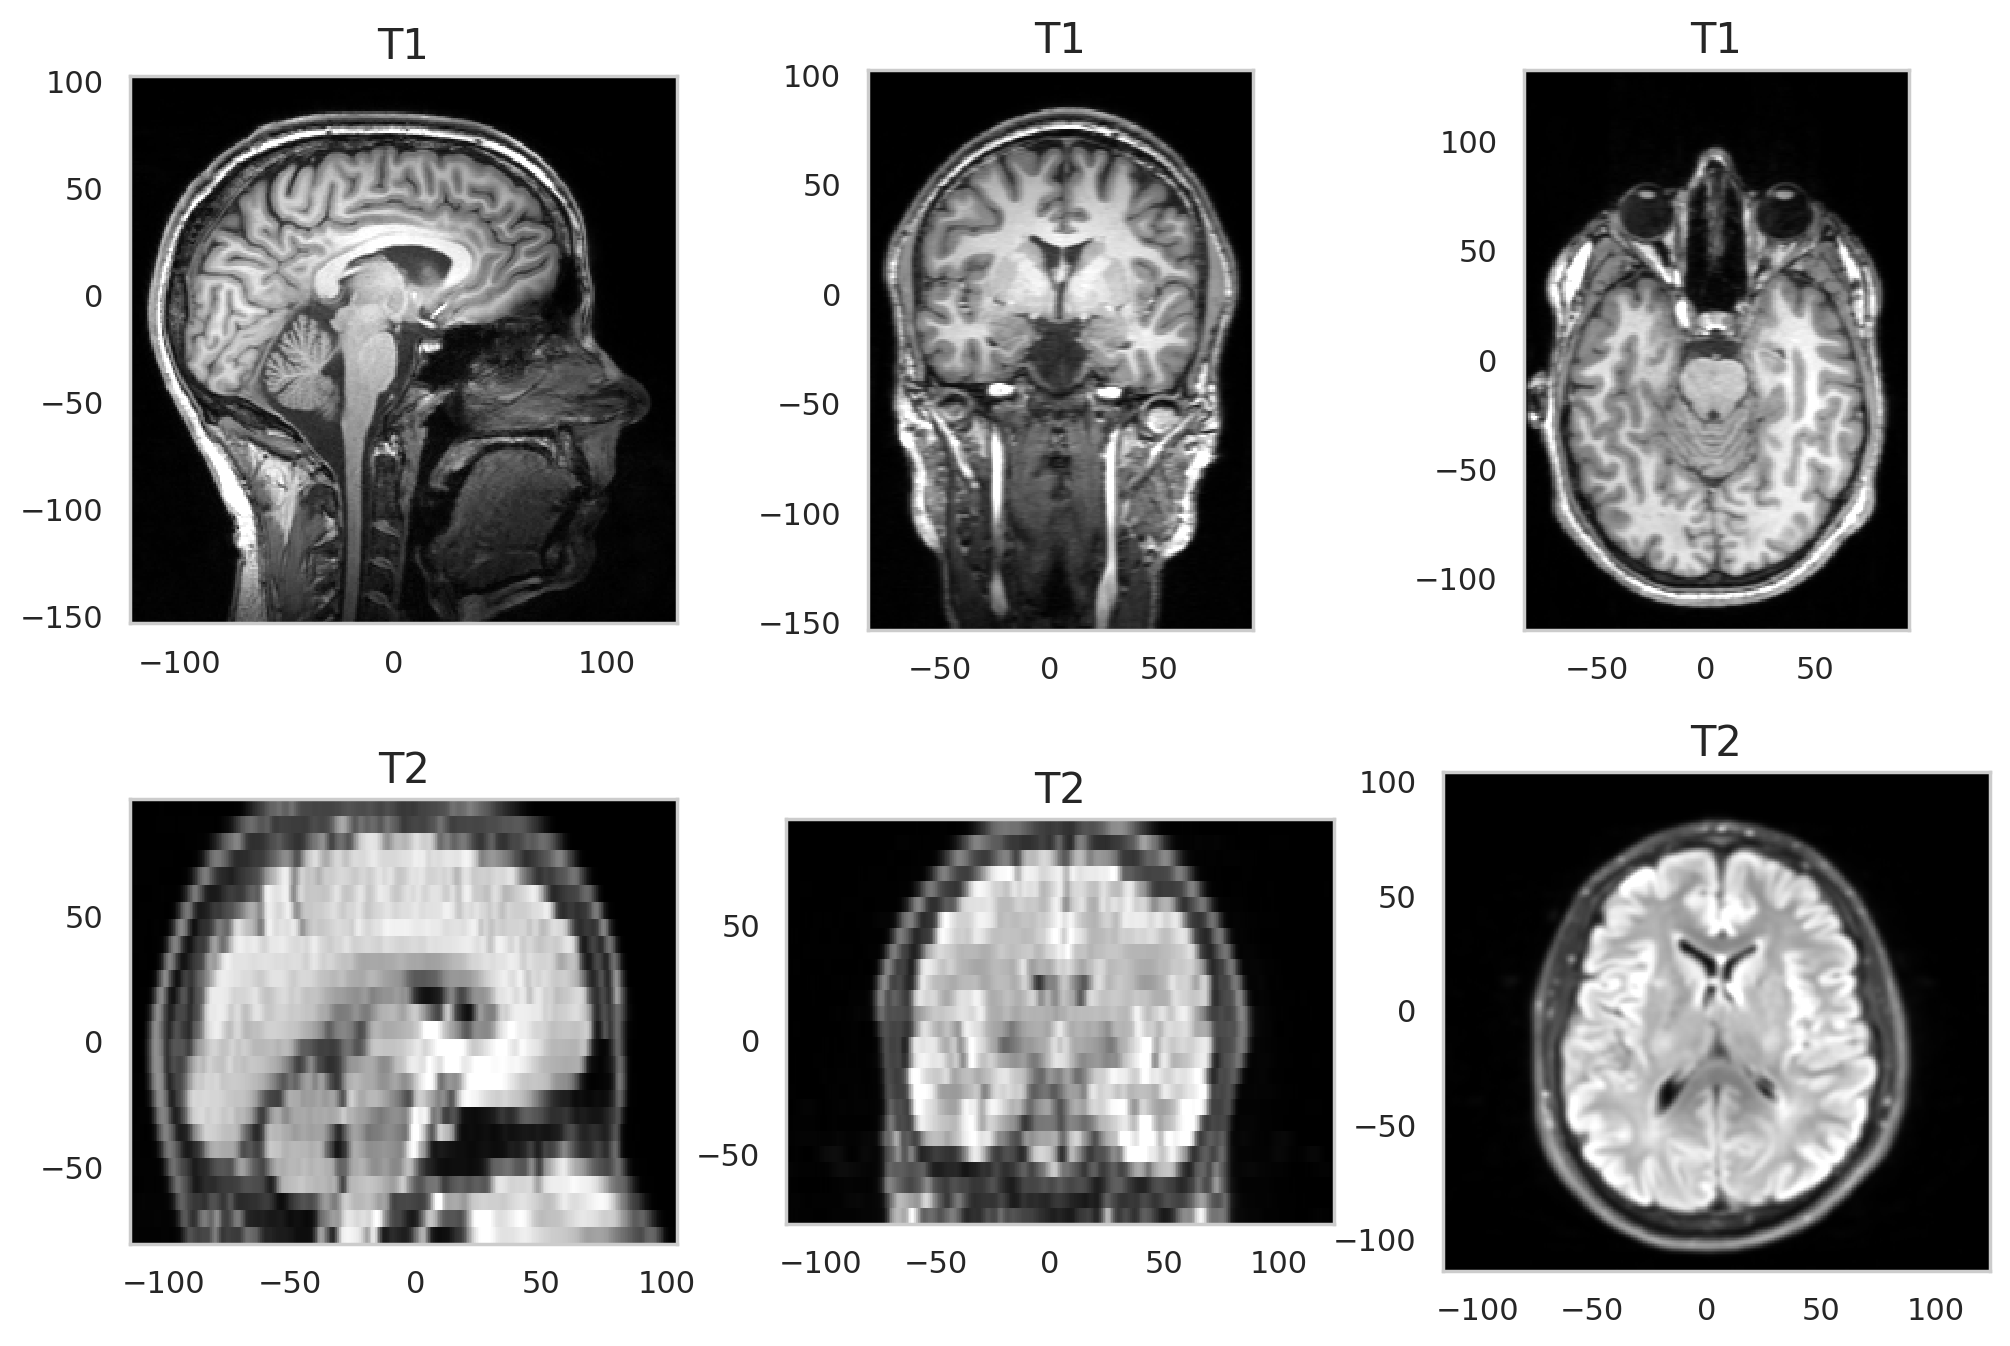

In [26]:
# add a ramdom blur
blur = tio.RandomBlur()
fpg_ras_blur = blur(fpg_ras)
show_fpg(fpg_ras_blur)

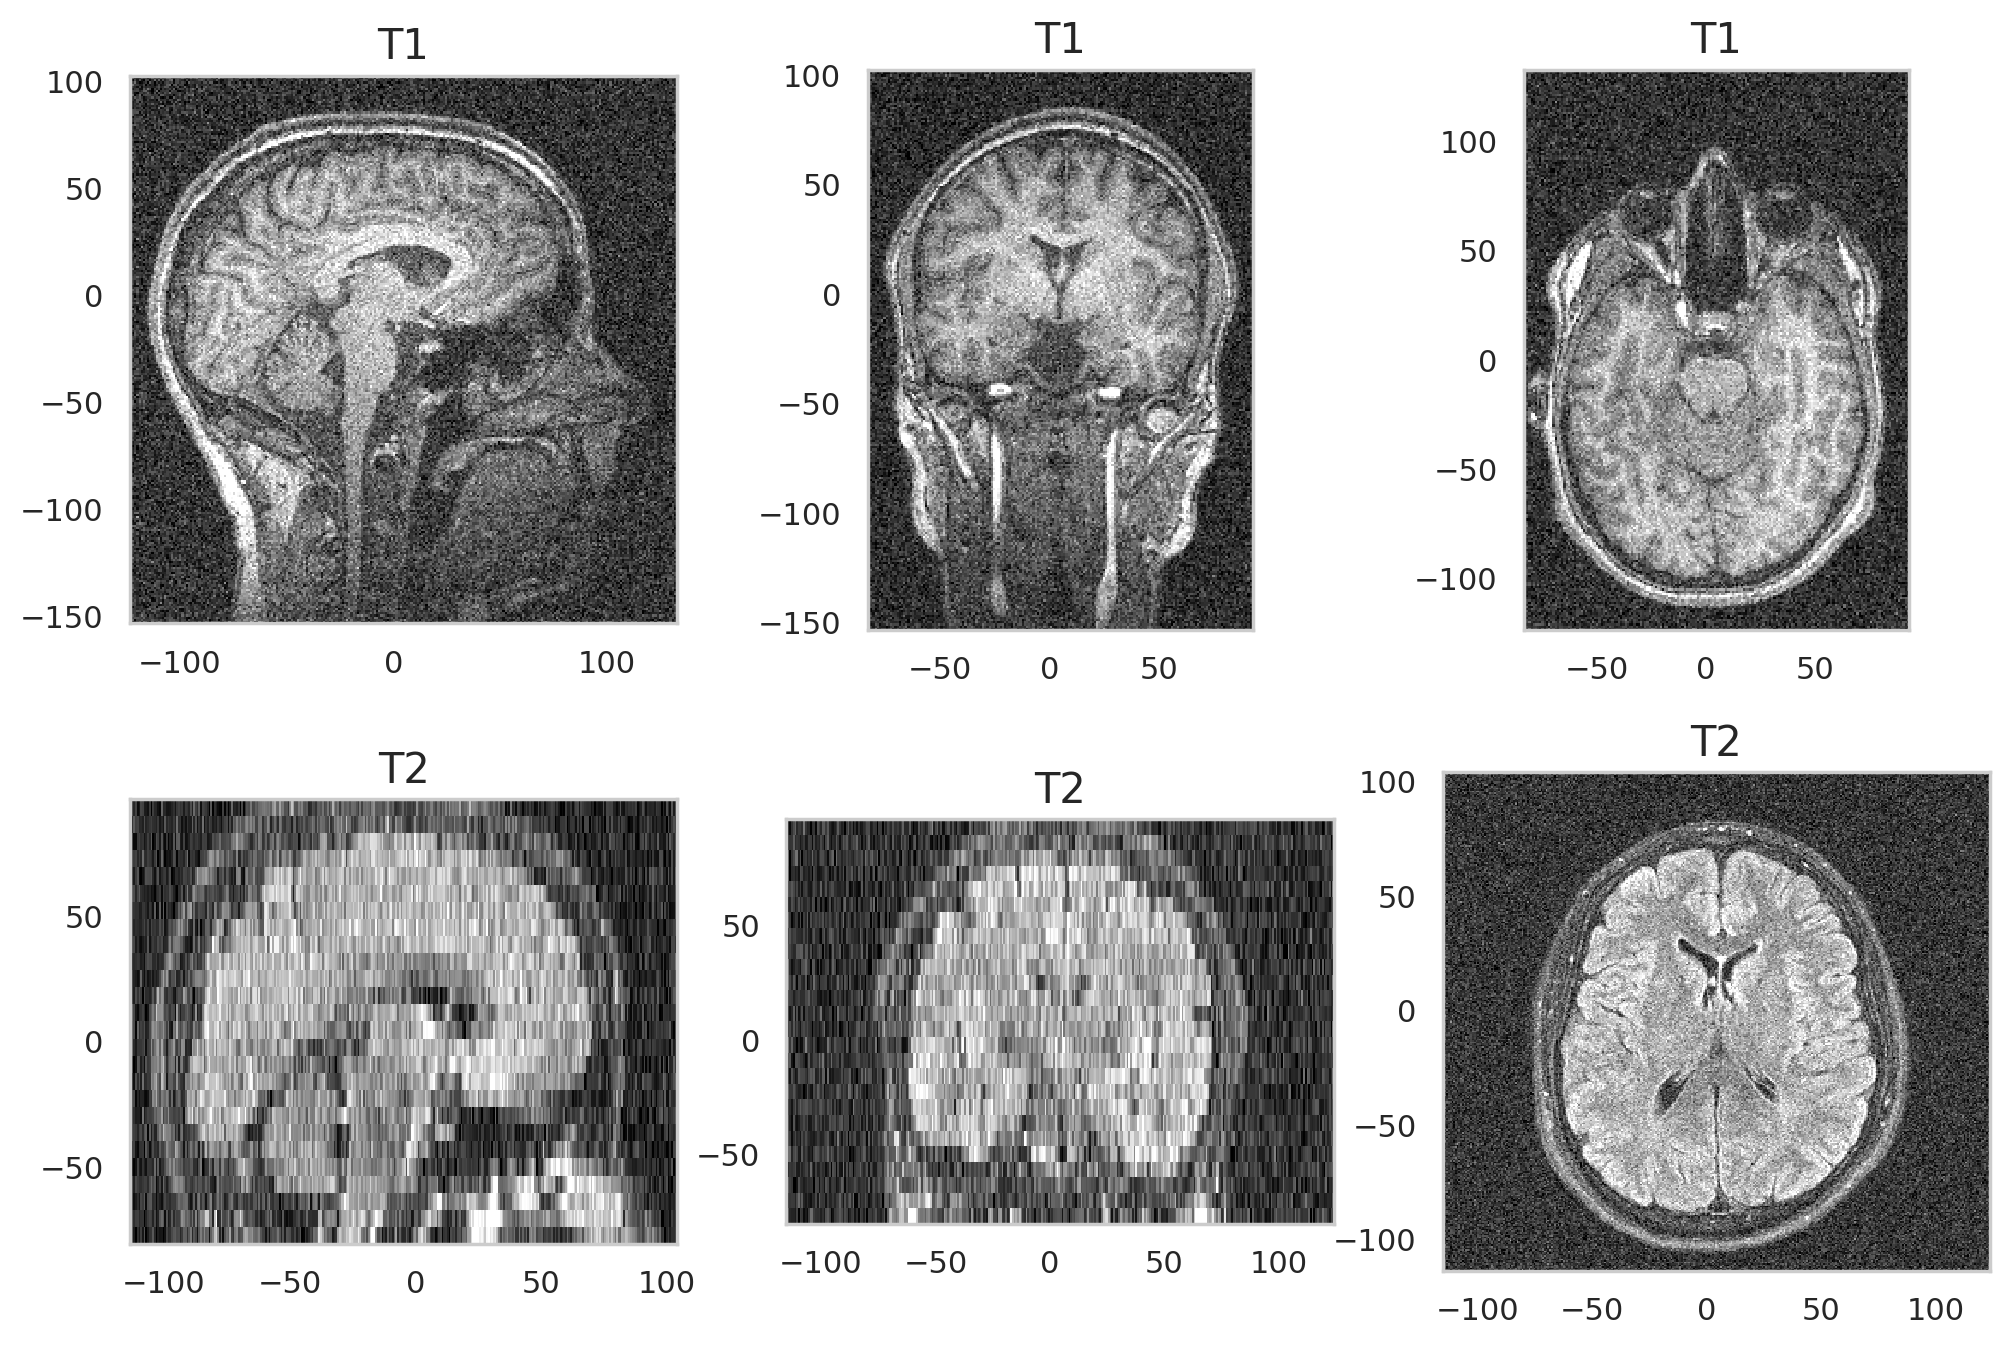

In [27]:
# add a random noise to the dataset
standardize = tio.ZNormalization()
add_noise = tio.RandomNoise(std = 0.5)
standard = standardize(fpg_ras)
fpg_ras_noise = add_noise(standard)
show_fpg(fpg_ras_noise)

Addition to Random Spikes


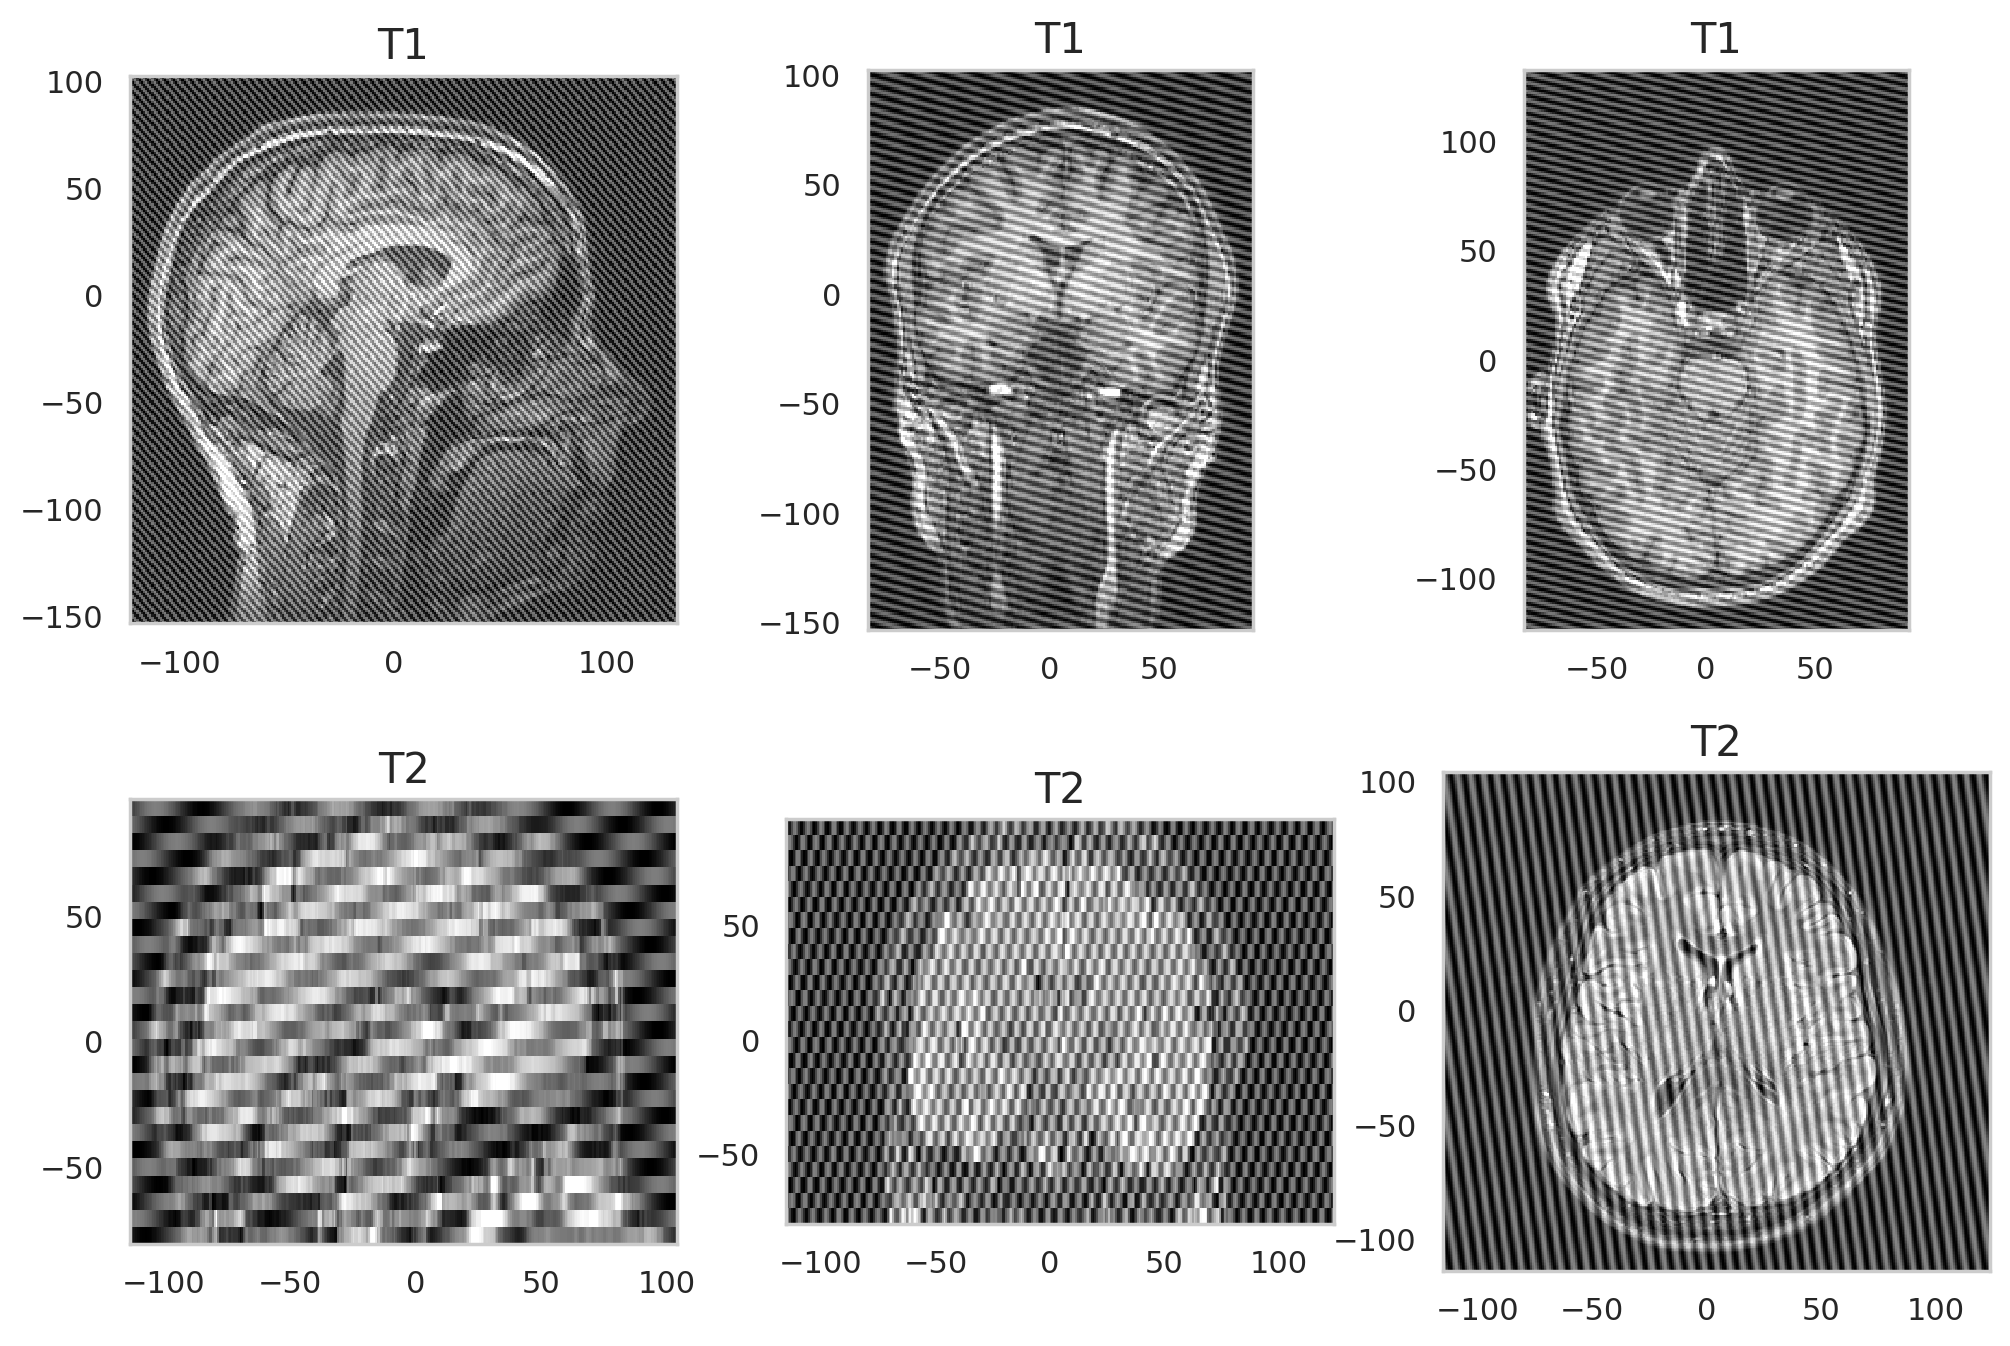

In [28]:
# add k-transformation
# add a random spike
add_spike = tio.RandomSpike()
fpg_ras_spike = add_spike(fpg_ras)
show_fpg(fpg_ras_spike)
print("Addition to Random Spikes")





Addition of Random Ghosting


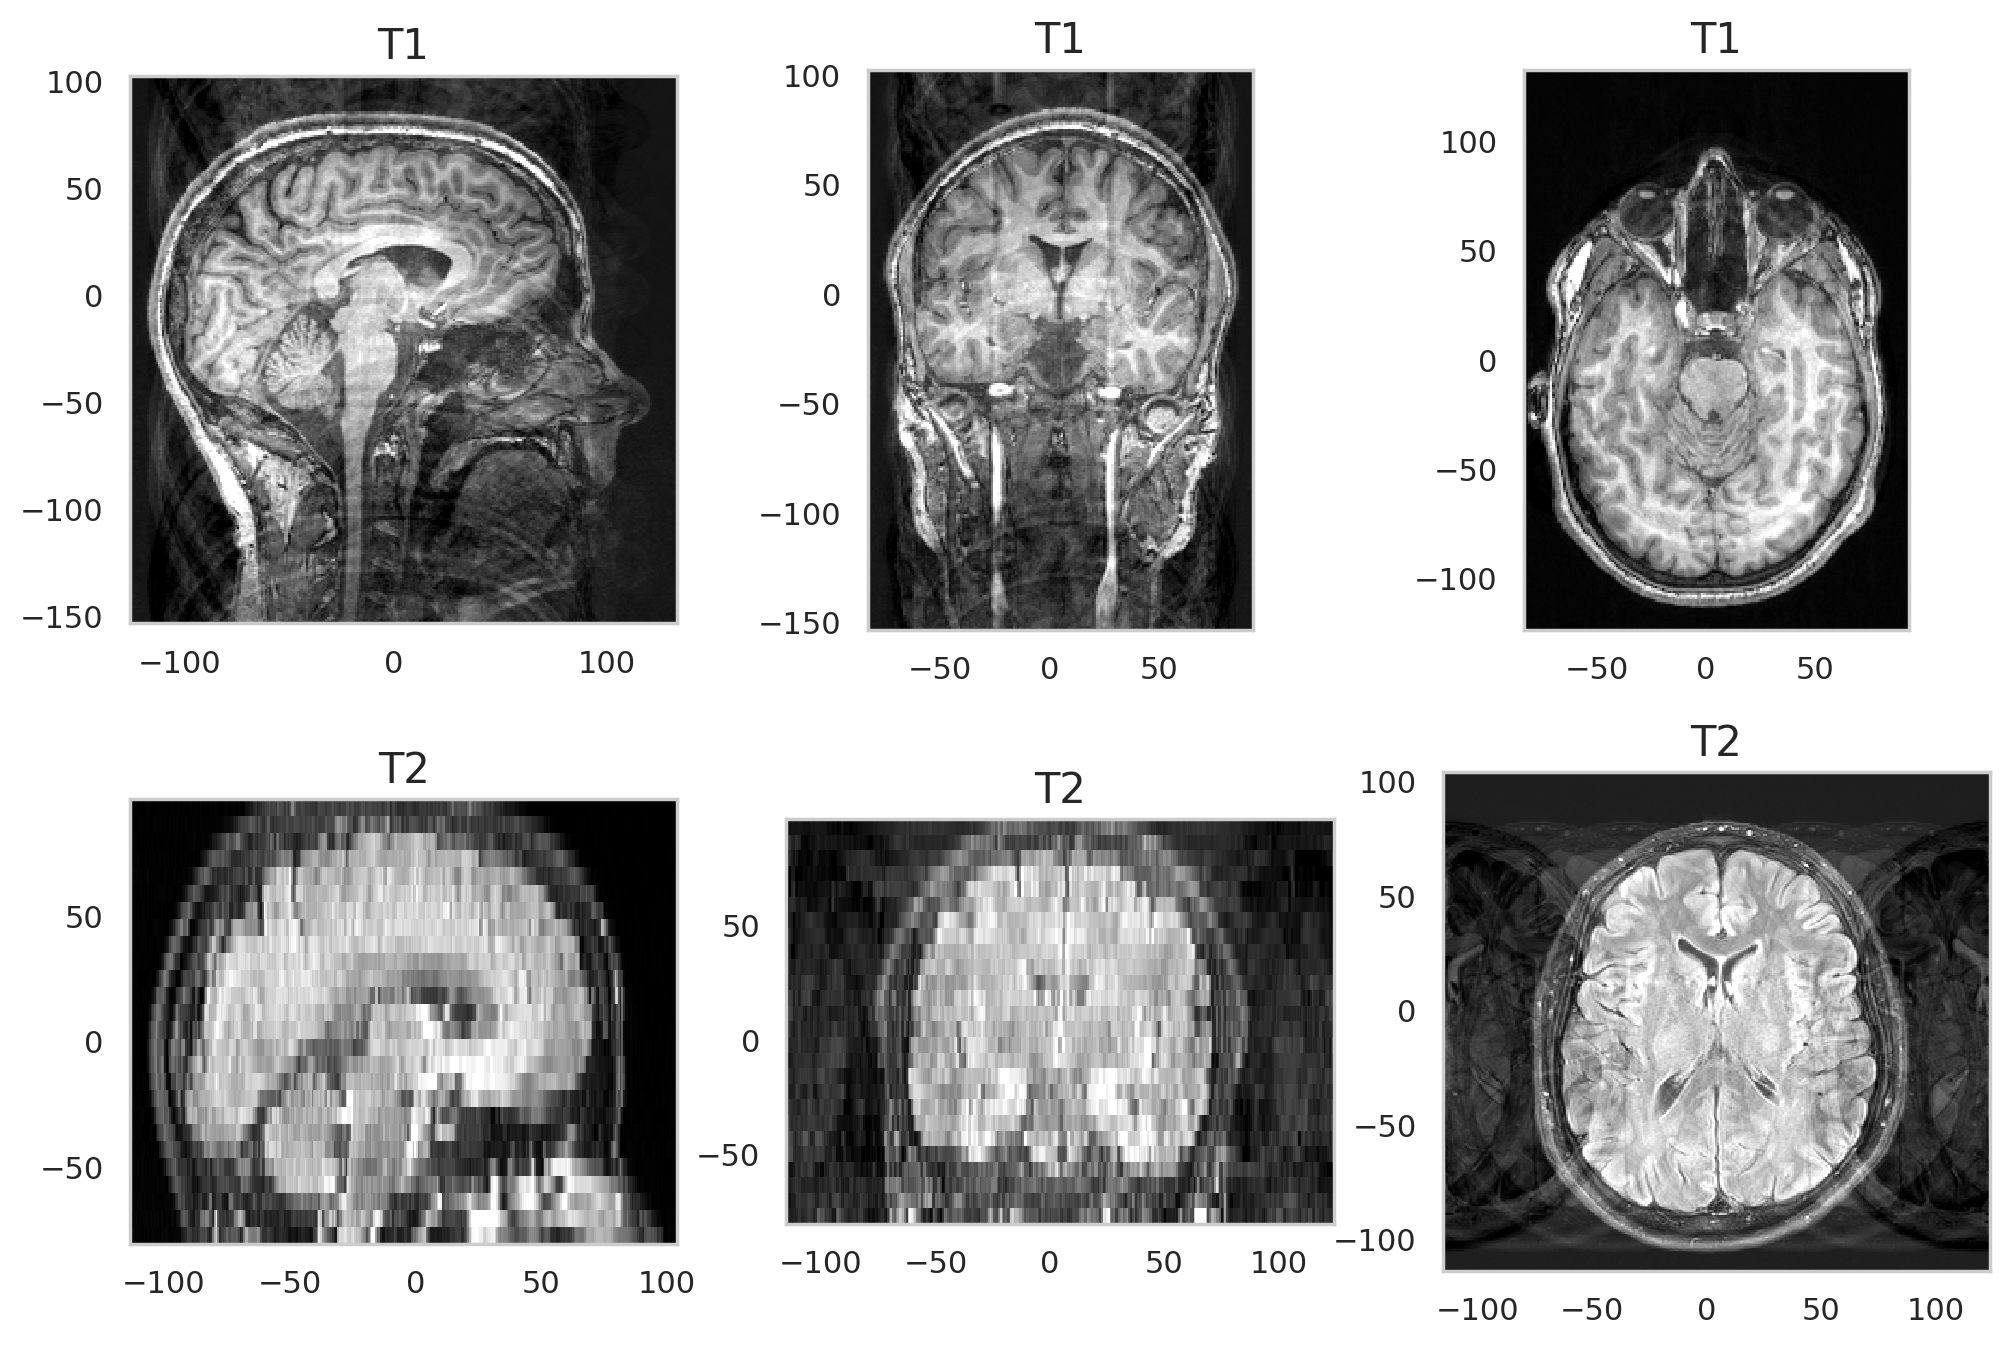

In [29]:
# add random ghosting
add_ghosts = tio.RandomGhosting(intensity = 1.5)
fpg_ras_ghosts = add_ghosts(fpg_ras)
show_fpg(fpg_ras_ghosts)
print("Addition of Random Ghosting")


Addition of Random Motion


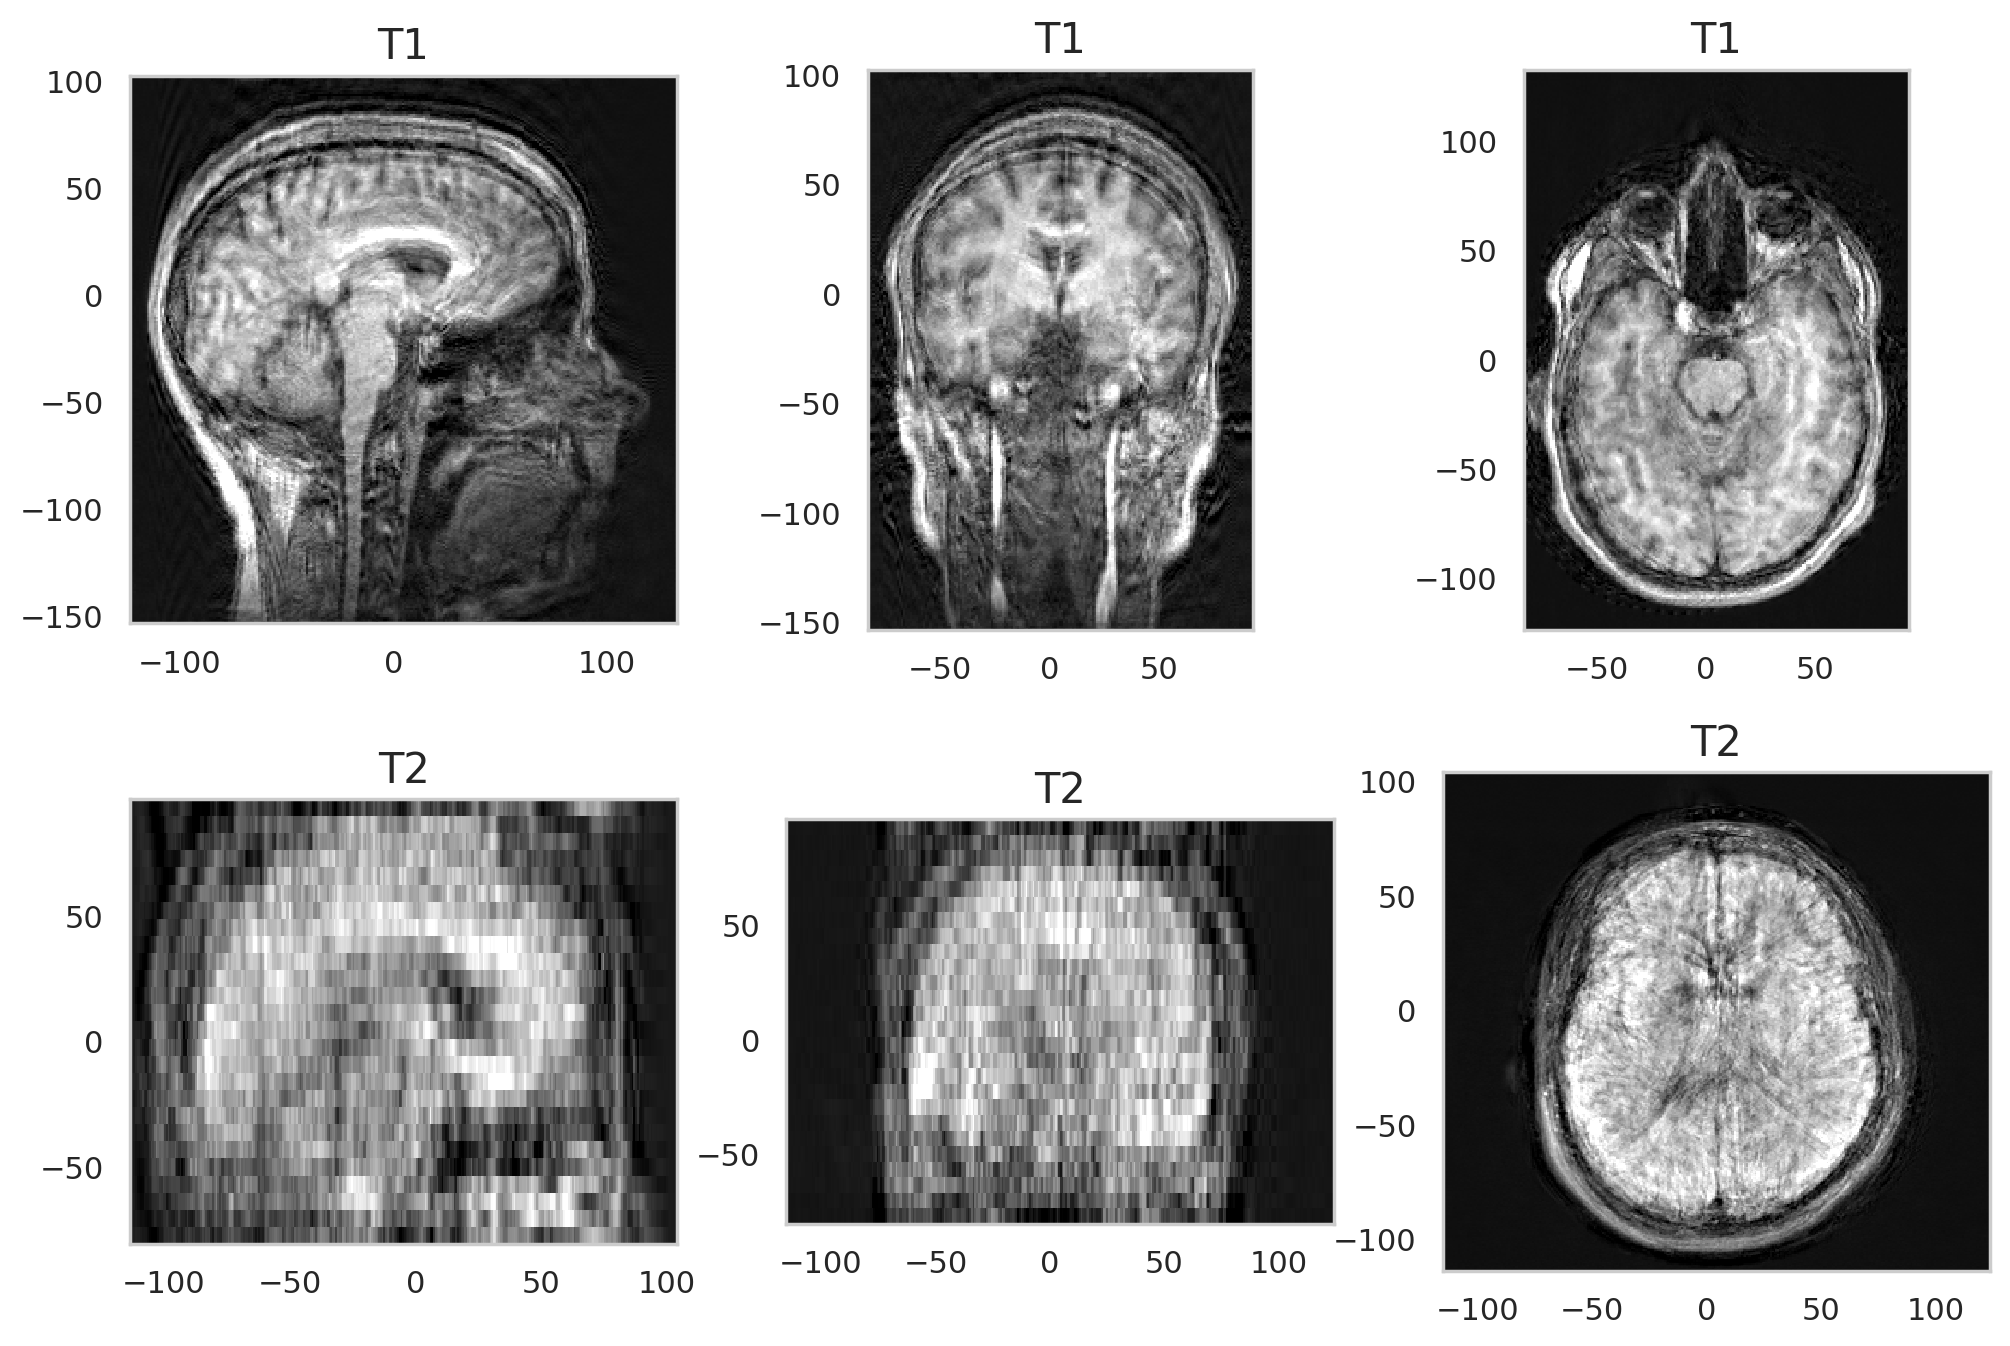

In [7]:
# add random motion
add_motion = tio.RandomMotion(num_transforms = 6, image_interpolation = "nearest")
fpg_ras_motion = add_motion(fpg_ras)
show_fpg(fpg_ras_motion)
print("Addition of Random Motion")

# Exercise 5 (bonus): Apply a chain of transformations

## Your task:
Use Compose to chain some of the above transformations of your choice (from exercises 2-4) and apply them on our dataset
- Be mindful of RAM limits
- Use `OneOf` and the `p` kwarg wisely

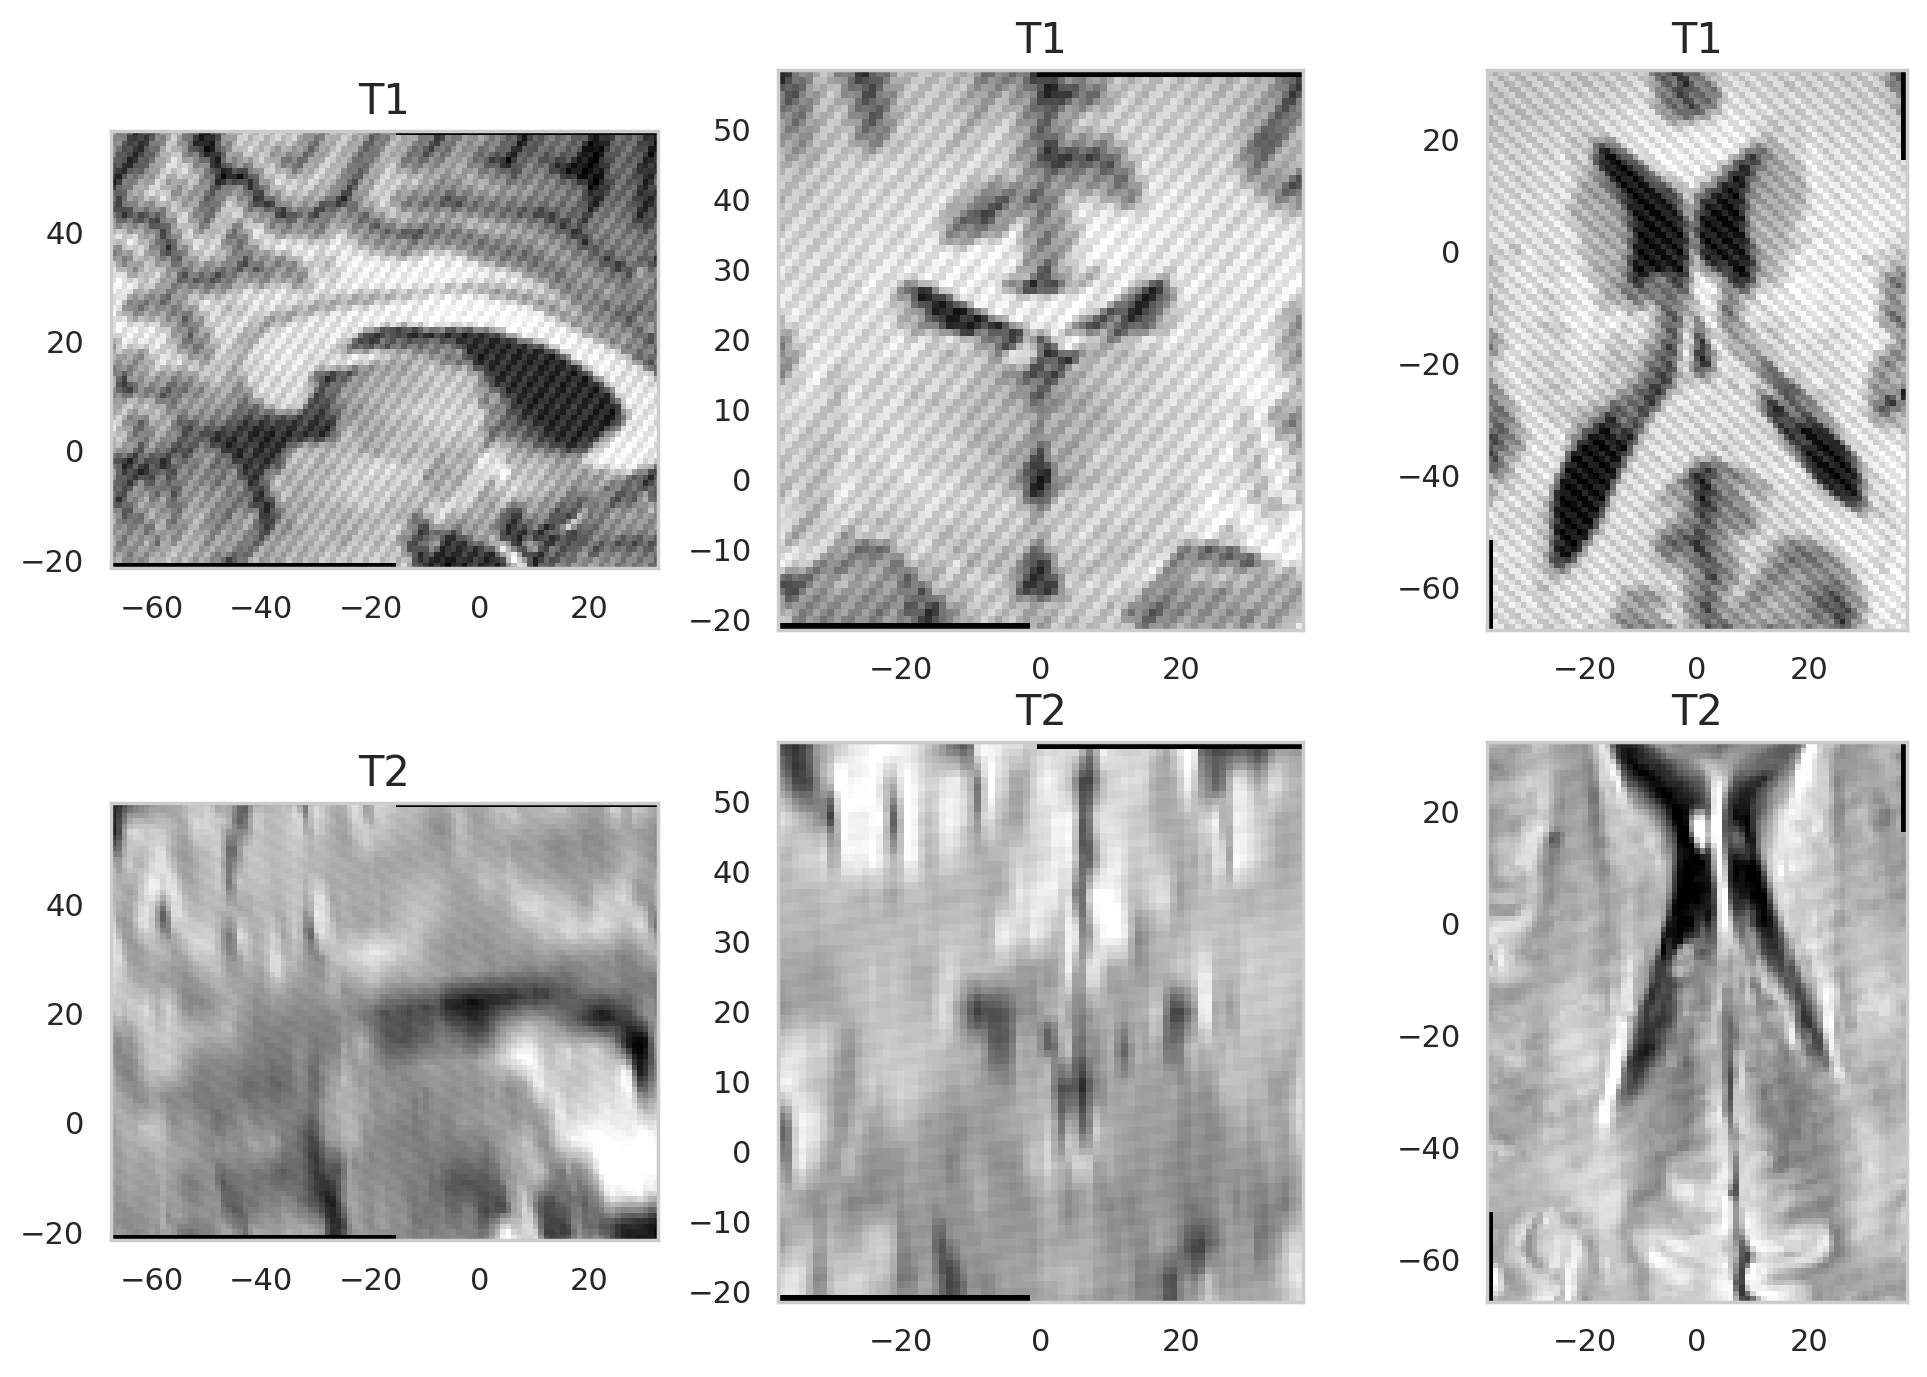

In [8]:
# Type your code here
get_foreground = tio.ZNormalization.mean

training_transform = tio.Compose([
    tio.Resample(
        mni.t1.path,
        pre_affine_name='affine_matrix'),      # to MNI space (which is RAS+)
    tio.RandomAnisotropy(p=0.25),              # make images look anisotropic 25% of times
    tio.CropOrPad((75, 100, 80)),              # tight crop to save RAM
    tio.ZNormalization(
        masking_method=get_foreground),        # zero mean, unit variance of foreground
    tio.RandomBlur(p=0.25),                    # blur 25% of times
    tio.RandomNoise(p=0.25),                   # Gaussian noise 25% of times
    tio.OneOf({                                # either
        tio.RandomAffine(): 0.8,               # random affine
        tio.RandomElasticDeformation(): 0.2,   # or random elastic deformation
    }, p=0.8),                                 # applied to 80% of images
    tio.RandomBiasField(p=0.3),                # magnetic field inhomogeneity 30% of times
    tio.OneOf({                                # either
        tio.RandomMotion(): 1,                 # random motion artifact
        tio.RandomSpike(): 2,                  # or spikes
        tio.RandomGhosting(): 2,               # or ghosts
    }, p=0.5),                                 # applied to 50% of images
])

fpg_training = copy.deepcopy(fpg_ras)
fpg_augmented = training_transform(fpg_training) # apply the transform
show_fpg(fpg_augmented)    

# Congratulations! You know how to load, display and pre-process MRI images

#Assignment Solution

[solution](https://colab.research.google.com/drive/1NFj_xhQmqEM5aS36Lc3CHv9o1_zBtxOG?usp=sharing)

Only look at the solutions when you have attempted the exercises

# References:

[BraTS2020 Dataset](https://www.kaggle.com/datasets/awsaf49/brats20-dataset-training-validation) from Kaggle.


